# 🧬 酵母四分体菌落图像分析教程
## Colony Image Analysis Tutorial for Yeast Tetrad Dissection

---

### 📋 教程目标

本教程将带你从零开始学习如何：
1. **图像预处理**: 灰度转换、高斯模糊、阈值分割
2. **菌落检测**: 形态学操作、分水岭分割、质心提取
3. **图像对齐**: 匈牙利算法匹配、RANSAC 仿射变换
4. **基因型判断**: 网格拟合、信号测量、SNR 分析

### 🎯 应用场景

- **Tetrad 平板 (基准图)**: 四分体解剖后的黑底平板，每个 tetrad 有 4 个孢子
- **HYG 平板 (筛选图)**: 转印后的潮霉素筛选平板
  - **Non-Essential Gene**: DEL 有 HYG 抗性能生长，WT 不长
  - **Essential Gene**: DEL 致死不长，WT 无抗性也不长

### 📚 教程结构

| 章节 | 内容 | 重点概念 |
|------|------|----------|
| 1 | 环境配置与库导入 | matplotlib, OpenCV, scikit-image |
| 2 | 图像读取与显示 | RGB vs BGR, dtype |
| 3 | 灰度转换 | 通道选择策略 |
| 4 | 高斯模糊 | σ 参数调优 |
| 5 | Otsu 阈值分割 | 自动阈值原理 |
| 6 | 形态学操作 | 开运算、闭运算 |
| 7 | 分水岭分割 | 融合菌落分离 |
| 8 | 区域属性提取 | regionprops, centroid |
| 9 | 图像对齐 | 仿射变换, RANSAC |
| 10 | 网格拟合 | PCA 旋转校正 |
| 11 | 信号测量与基因型判断 | SNR, 背景建模 |

---

> **💡 提示**: 本教程中所有代码均可直接运行，请按顺序执行每个 Cell。

---
## 第一章：环境配置与库导入

在开始图像分析之前，我们需要：
1. **设置全局字体** — 确保图表使用 Arial 字体
2. **导入必要的库** — 包括图像处理、数值计算和可视化工具

### 依赖库说明

| 库名 | 用途 |
|------|------|
| **NumPy** | 数值计算，数组操作 |
| **Matplotlib** | 图像可视化，绑制图表 |
| **OpenCV (cv2)** | 图像对齐，仿射变换 |
| **scikit-image** | 图像分割，特征提取 |
| **SciPy** | 距离计算，优化算法 |

In [53]:
# ============================================================
# 1.1 Global Font Settings - Use Arial Font
# ============================================================

import matplotlib
import matplotlib.pyplot as plt

# Set Matplotlib global font to Arial
# If Arial is not available, it will fallback to DejaVu Sans
plt.rcParams.update({
    'axes.unicode_minus': False,  # Correctly display minus sign
    'figure.dpi': 100,            # Image resolution
    'axes.titlesize': 12,         # Title font size
    'axes.labelsize': 10,         # Axis label font size
})

In [54]:
# ============================================================
# 1.2 Import Required Libraries
# ============================================================

import numpy as np
from matplotlib.patches import Circle

# OpenCV - Image alignment and affine transformation
import cv2

# scikit-image - Image processing toolkit
from skimage import io, filters, measure, morphology
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.filters import gaussian, threshold_otsu

# scipy - Distance calculation and optimization
from scipy.spatial import distance
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment, minimize
from scipy import ndimage

# Verify imports
print("✅ All libraries imported successfully!")
print(f"   OpenCV version: {cv2.__version__}")
print(f"   NumPy version: {np.__version__}")

✅ All libraries imported successfully!
   OpenCV version: 4.12.0
   NumPy version: 2.2.6


---
## 🔧 核心函数库

本 notebook 中所有功能都封装为可复用的函数，方便在其他脚本中使用。

### 函数分类

| 类别 | 函数 | 功能 |
|------|------|------|
| **图像预处理** | `convert_to_grayscale()` | 灰度转换 |
| | `apply_gaussian_blur()` | 高斯模糊 |
| | `binarize_image()` | Otsu 阈值二值化 |
| | `apply_morphology()` | 形态学操作 |
| **菌落检测** | `detect_colonies()` | 菌落质心检测 |
| | `watershed_segmentation()` | 分水岭分割 |
| **图像对齐** | `match_points()` | 匈牙利算法匹配 |
| | `align_images()` | 仿射变换对齐 |
| **网格拟合** | `detect_rotation_angle()` | 旋转角度检测 |
| | `fit_grid_simple()` | 简单网格拟合 |
| | `fit_grid_with_rotation()` | 带旋转校正的网格拟合 |
| | `fit_grid_optimized()` | 旋转+平移优化 |
| **信号测量** | `measure_signal_at_positions()` | 测量指定位置信号 |
| | `estimate_background()` | 背景估计 |
| | `calculate_snr()` | 计算信噪比 |
| **基因型判断** | `decide_genotype_comprehensive()` | 综合判断基因型 |
| **完整流程** | `analyze_tetrad_hyg_pair()` | 一键分析完整流程 |

In [55]:
# ============================================================
# PART 1: 图像预处理函数
# ============================================================

def convert_to_grayscale(image, method='mean', channel=None):
    """
    将彩色图像转换为灰度图
    
    Args:
        image: 输入图像 (H, W, 3)
        method: 'mean' | 'weighted' | 'channel'
        channel: 当 method='channel' 时指定通道 (0=R, 1=G, 2=B)
    
    Returns:
        gray: 灰度图 (H, W)
    """
    if image.ndim == 2:
        return image.astype(float)
    
    if method == 'mean':
        return np.mean(image, axis=2)
    elif method == 'weighted':
        # 模拟人眼感知
        return 0.299 * image[:, :, 0] + 0.587 * image[:, :, 1] + 0.114 * image[:, :, 2]
    elif method == 'channel':
        if channel is None:
            raise ValueError("Must specify channel when method='channel'")
        return image[:, :, channel].astype(float)
    else:
        raise ValueError(f"Unknown method: {method}")


def apply_gaussian_blur(image, sigma=1.0):
    """
    应用高斯模糊
    
    Args:
        image: 输入图像
        sigma: 高斯核标准差
    
    Returns:
        blurred: 模糊后的图像
    """
    from skimage.filters import gaussian
    return gaussian(image, sigma=sigma, preserve_range=True)


def binarize_image(image, method='otsu', threshold=None):
    """
    图像二值化
    
    Args:
        image: 输入灰度图
        method: 'otsu' | 'manual'
        threshold: 当 method='manual' 时的阈值
    
    Returns:
        binary: 二值图
        threshold_value: 使用的阈值
    """
    from skimage.filters import threshold_otsu
    
    if method == 'otsu':
        try:
            threshold_value = threshold_otsu(image)
        except:
            threshold_value = np.mean(image)
    elif method == 'manual':
        if threshold is None:
            raise ValueError("Must specify threshold when method='manual'")
        threshold_value = threshold
    else:
        raise ValueError(f"Unknown method: {method}")
    
    binary = image > threshold_value
    return binary, threshold_value


def apply_morphology(binary_image, operation='opening', selem_type='disk', selem_size=3):
    """
    应用形态学操作
    
    Args:
        binary_image: 二值图像
        operation: 'opening' | 'closing' | 'erosion' | 'dilation'
        selem_type: 'disk' | 'square'
        selem_size: 结构元素大小
    
    Returns:
        result: 处理后的二值图
    """
    from skimage import morphology
    
    # 创建结构元素
    if selem_type == 'disk':
        selem = morphology.disk(selem_size)
    elif selem_type == 'square':
        selem = morphology.square(selem_size)
    else:
        raise ValueError(f"Unknown selem_type: {selem_type}")
    
    # 应用操作
    if operation == 'opening':
        return morphology.binary_opening(binary_image, selem)
    elif operation == 'closing':
        return morphology.binary_closing(binary_image, selem)
    elif operation == 'erosion':
        return morphology.binary_erosion(binary_image, selem)
    elif operation == 'dilation':
        return morphology.binary_dilation(binary_image, selem)
    else:
        raise ValueError(f"Unknown operation: {operation}")


# ============================================================
# PART 2: 菌落检测函数
# ============================================================

def detect_colonies(image, is_hyg=False, sigma=1.0, min_area=20, morph_size=3):
    """
    检测图像中的菌落质心
    
    Args:
        image: 输入图像 (可以是灰度图或彩色图)
        is_hyg: 是否为 HYG 平板 (绿色背景)
        sigma: 高斯模糊参数
        min_area: 最小菌落面积 (像素)
        morph_size: 形态学操作结构元素大小
    
    Returns:
        centroids: 质心列表 [(x1, y1), (x2, y2), ...]
        binary_mask: 二值掩膜
        props: regionprops 对象列表
    """
    from skimage import measure
    
    # 灰度转换
    if image.ndim == 3:
        if is_hyg:
            gray = image[:, :, 0].astype(float)  # HYG: 红色通道
        else:
            gray = np.mean(image, axis=2)  # Tetrad: 平均值
    else:
        gray = image.astype(float)
    
    # 预处理
    blurred = apply_gaussian_blur(gray, sigma=sigma)
    binary, _ = binarize_image(blurred, method='otsu')
    cleaned = apply_morphology(binary, operation='opening', selem_size=morph_size)
    
    # 标记连通区域
    labeled = measure.label(cleaned)
    props = measure.regionprops(labeled)
    
    # 提取质心
    centroids = []
    valid_props = []
    for prop in props:
        if prop.area >= min_area:
            y, x = prop.centroid
            centroids.append((x, y))
            valid_props.append(prop)
    
    return centroids, cleaned, valid_props


def watershed_segmentation(binary_mask, min_distance=20):
    """
    使用分水岭算法分离融合的菌落
    
    Args:
        binary_mask: 二值掩膜
        min_distance: 局部最大值之间的最小距离
    
    Returns:
        labels: 分水岭标记图
        n_colonies: 检测到的菌落数量
    """
    from scipy import ndimage
    from skimage.feature import peak_local_max
    from skimage.segmentation import watershed
    from skimage import measure
    
    # 距离变换
    distance_map = ndimage.distance_transform_edt(binary_mask)
    
    # 找局部最大值
    coords = peak_local_max(distance_map, min_distance=min_distance, 
                           labels=binary_mask.astype(int))
    
    # 创建标记
    from skimage import morphology
    markers = np.zeros(distance_map.shape, dtype=int)
    markers[tuple(coords.T)] = np.arange(1, len(coords) + 1)
    markers = morphology.binary_dilation(markers > 0, morphology.disk(2))
    markers = measure.label(markers)
    
    # 分水岭分割
    labels = watershed(-distance_map, markers, mask=binary_mask)
    
    return labels, labels.max()


# ============================================================
# PART 3: 图像对齐函数
# ============================================================

def match_points(points1, points2, max_distance=None):
    """
    使用匈牙利算法匹配两组点
    
    Args:
        points1: 参考点集 [(x, y), ...]
        points2: 目标点集 [(x, y), ...]
        max_distance: 最大匹配距离 (像素)，超过此距离的匹配将被过滤
    
    Returns:
        matched_pts1: 匹配的参考点
        matched_pts2: 匹配的目标点
        n_matched: 匹配对数
    """
    from scipy.spatial.distance import cdist
    from scipy.optimize import linear_sum_assignment
    
    if len(points1) == 0 or len(points2) == 0:
        return np.array([]), np.array([]), 0
    
    pts1 = np.array(points1, dtype=np.float32)
    pts2 = np.array(points2, dtype=np.float32)
    
    # 计算距离矩阵
    dist_matrix = cdist(pts1, pts2)
    
    # 匈牙利算法
    row_ind, col_ind = linear_sum_assignment(dist_matrix)
    
    # 过滤距离过大的匹配
    if max_distance is not None:
        valid = dist_matrix[row_ind, col_ind] < max_distance
        row_ind = row_ind[valid]
        col_ind = col_ind[valid]
    
    matched_pts1 = pts1[row_ind]
    matched_pts2 = pts2[col_ind]
    
    return matched_pts1, matched_pts2, len(matched_pts1)


def align_images(source_img, target_img, src_points, dst_points, 
                 min_matches=3, ransac_thresh=5.0):
    """
    使用仿射变换对齐图像
    
    Args:
        source_img: 源图像
        target_img: 目标图像 (用于获取尺寸)
        src_points: 源图像特征点
        dst_points: 目标图像特征点
        min_matches: 最少匹配点数
        ransac_thresh: RANSAC 阈值
    
    Returns:
        aligned_img: 对齐后的图像
        transform_matrix: 变换矩阵 (2x3)
        transform_params: 变换参数字典 (scale, angle, tx, ty)
    """
    h, w = target_img.shape[:2]
    aligned_img = source_img.copy()
    transform_matrix = None
    transform_params = None
    
    if len(src_points) < min_matches or len(dst_points) < min_matches:
        return aligned_img, transform_matrix, transform_params
    
    src_pts = np.array(src_points, dtype=np.float32).reshape(-1, 1, 2)
    dst_pts = np.array(dst_points, dtype=np.float32).reshape(-1, 1, 2)
    
    # RANSAC 估计仿射变换
    M, inliers = cv2.estimateAffinePartial2D(
        src_pts, dst_pts, 
        method=cv2.RANSAC, 
        ransacReprojThreshold=ransac_thresh
    )
    
    if M is not None:
        aligned_img = cv2.warpAffine(source_img, M, (w, h))
        
        # 提取变换参数
        scale = np.sqrt(M[0, 0]**2 + M[0, 1]**2)
        angle_deg = np.degrees(np.arctan2(M[1, 0], M[0, 0]))
        tx, ty = M[0, 2], M[1, 2]
        
        transform_params = {
            'scale': scale,
            'angle': angle_deg,
            'tx': tx,
            'ty': ty
        }
        transform_matrix = M
    
    return aligned_img, transform_matrix, transform_params


# ============================================================
# PART 4: 网格拟合函数
# ============================================================

def detect_rotation_angle(centroids, n_rows=4, n_cols=12):
    """
    检测菌落阵列的旋转角度
    
    Args:
        centroids: 质心列表 [(x, y), ...]
        n_rows: 行数
        n_cols: 列数
    
    Returns:
        angle_deg: 旋转角度 (度)
        row_angles: 各行角度列表
    """
    pts = np.array(centroids)
    n_pts = len(pts)
    
    if n_pts < n_cols:
        return 0.0, []
    
    # 按 y 坐标排序
    sorted_indices = np.argsort(pts[:, 1])
    pts_sorted = pts[sorted_indices]
    
    # 分成行
    pts_per_row = n_pts // n_rows
    row_angles = []
    
    for i in range(n_rows):
        start_idx = i * pts_per_row
        end_idx = start_idx + pts_per_row if i < n_rows - 1 else n_pts
        row_pts = pts_sorted[start_idx:end_idx]
        
        if len(row_pts) >= 2:
            # 按 x 坐标排序
            row_pts = row_pts[np.argsort(row_pts[:, 0])]
            
            if len(row_pts) >= 3:
                # 多点：计算相邻点斜率的中位数
                slopes = []
                for j in range(len(row_pts) - 1):
                    dx = row_pts[j+1, 0] - row_pts[j, 0]
                    dy = row_pts[j+1, 1] - row_pts[j, 1]
                    if abs(dx) > 1:
                        slopes.append(dy / dx)
                if slopes:
                    angle = np.degrees(np.arctan(np.median(slopes)))
                    row_angles.append(angle)
            else:
                # 两点：直接计算斜率
                dx = row_pts[-1, 0] - row_pts[0, 0]
                dy = row_pts[-1, 1] - row_pts[0, 1]
                if abs(dx) > 1:
                    angle = np.degrees(np.arctan(dy / dx))
                    row_angles.append(angle)
    
    if not row_angles:
        return 0.0, []
    
    angle_deg = np.median(row_angles)
    angle_deg = np.clip(angle_deg, -15, 15)  # 限制范围
    
    return angle_deg, row_angles


def rotate_points(points, angle_deg, center):
    """
    围绕中心点旋转点集
    
    Args:
        points: 点列表或数组
        angle_deg: 旋转角度 (度)
        center: 旋转中心 (x, y)
    
    Returns:
        rotated: 旋转后的点
    """
    angle_rad = np.radians(angle_deg)
    cos_a, sin_a = np.cos(angle_rad), np.sin(angle_rad)
    
    pts = np.array(points)
    pts_centered = pts - center
    
    rotated = np.zeros_like(pts_centered)
    rotated[:, 0] = pts_centered[:, 0] * cos_a - pts_centered[:, 1] * sin_a
    rotated[:, 1] = pts_centered[:, 0] * sin_a + pts_centered[:, 1] * cos_a
    
    return rotated + center


def fit_grid_simple(centroids, n_rows=4, n_cols=12):
    """
    简单网格拟合：基于边界框
    
    Args:
        centroids: 质心列表 [(x, y), ...]
        n_rows: 行数
        n_cols: 列数
    
    Returns:
        grid: 网格点数组 (n_rows, n_cols, 2)
        params: 参数字典
    """
    pts = np.array(centroids)
    x_min, x_max = pts[:, 0].min(), pts[:, 0].max()
    y_min, y_max = pts[:, 1].min(), pts[:, 1].max()
    
    x_spacing = (x_max - x_min) / (n_cols - 1) if n_cols > 1 else 0
    y_spacing = (y_max - y_min) / (n_rows - 1) if n_rows > 1 else 0
    
    grid = np.zeros((n_rows, n_cols, 2))
    for row in range(n_rows):
        for col in range(n_cols):
            grid[row, col, 0] = x_min + col * x_spacing
            grid[row, col, 1] = y_min + row * y_spacing
    
    params = {
        'x_spacing': x_spacing,
        'y_spacing': y_spacing,
        'method': 'simple'
    }
    
    return grid, params


def fit_grid_with_rotation(centroids, n_rows=4, n_cols=12):
    """
    带旋转校正的网格拟合
    
    Args:
        centroids: 质心列表 [(x, y), ...]
        n_rows: 行数
        n_cols: 列数
    
    Returns:
        grid: 网格点数组 (n_rows, n_cols, 2)
        params: 参数字典
    """
    pts = np.array(centroids)
    center = pts.mean(axis=0)
    
    # 检测旋转角度
    angle_deg, row_angles = detect_rotation_angle(centroids, n_rows, n_cols)
    
    # 旋转质心到对齐状态
    pts_aligned = rotate_points(pts, -angle_deg, center)
    
    # 在对齐坐标系中拟合网格
    x_min, x_max = pts_aligned[:, 0].min(), pts_aligned[:, 0].max()
    y_min, y_max = pts_aligned[:, 1].min(), pts_aligned[:, 1].max()
    
    x_spacing = (x_max - x_min) / (n_cols - 1) if n_cols > 1 else 0
    y_spacing = (y_max - y_min) / (n_rows - 1) if n_rows > 1 else 0
    
    grid_aligned = np.zeros((n_rows, n_cols, 2))
    for row in range(n_rows):
        for col in range(n_cols):
            grid_aligned[row, col, 0] = x_min + col * x_spacing
            grid_aligned[row, col, 1] = y_min + row * y_spacing
    
    # 旋转网格回原始坐标系
    grid_flat = grid_aligned.reshape(-1, 2)
    grid_rotated = rotate_points(grid_flat, angle_deg, center)
    grid = grid_rotated.reshape(n_rows, n_cols, 2)
    
    params = {
        'x_spacing': x_spacing,
        'y_spacing': y_spacing,
        'rotation_angle': angle_deg,
        'row_angles': row_angles,
        'center': center,
        'method': 'rotation'
    }
    
    return grid, params


def fit_grid_optimized(centroids, n_rows=4, n_cols=12, max_translation=30.0):
    """
    优化的网格拟合：旋转 + 平移
    
    Args:
        centroids: 质心列表 [(x, y), ...]
        n_rows: 行数
        n_cols: 列数
        max_translation: 最大平移距离
    
    Returns:
        grid: 网格点数组 (n_rows, n_cols, 2)
        params: 参数字典
    """
    from scipy.optimize import minimize
    
    # 步骤1: 旋转校正
    grid_rotated, params_rot = fit_grid_with_rotation(centroids, n_rows, n_cols)
    
    def calculate_grid_error(grid, centroids):
        """计算网格点到最近质心的平均距离"""
        pts = np.array(centroids)
        grid_flat = grid.reshape(-1, 2)
        
        total_error = 0
        for gp in grid_flat:
            dists = np.linalg.norm(pts - gp, axis=1)
            total_error += np.min(dists)
        
        return total_error / len(grid_flat)
    
    error_after_rotation = calculate_grid_error(grid_rotated, centroids)
    
    # 步骤2: 网格搜索最佳平移
    best_tx, best_ty = 0.0, 0.0
    best_error = error_after_rotation
    
    search_range = np.arange(-20, 21, 5)
    for tx in search_range:
        for ty in search_range:
            grid_shifted = grid_rotated + np.array([tx, ty])
            err = calculate_grid_error(grid_shifted, centroids)
            if err < best_error:
                best_error = err
                best_tx, best_ty = tx, ty
    
    # 步骤3: 局部优化
    def objective(params):
        tx, ty = params
        grid_shifted = grid_rotated + np.array([tx, ty])
        return calculate_grid_error(grid_shifted, centroids)
    
    result = minimize(objective, [best_tx, best_ty], method='L-BFGS-B',
                     bounds=[(-max_translation, max_translation), 
                             (-max_translation, max_translation)])
    
    tx_opt, ty_opt = result.x
    error_final = calculate_grid_error(grid_rotated + np.array([tx_opt, ty_opt]), centroids)
    
    # 只在改进时使用平移
    if error_final < error_after_rotation:
        grid_final = grid_rotated + np.array([tx_opt, ty_opt])
        params_rot.update({
            'translation': (tx_opt, ty_opt),
            'translation_applied': True,
            'error': error_final,
            'method': 'optimized'
        })
    else:
        grid_final = grid_rotated
        params_rot.update({
            'translation': (0.0, 0.0),
            'translation_applied': False,
            'error': error_after_rotation,
            'method': 'rotation_only'
        })
    
    return grid_final, params_rot

print("✅ Part 1-4: 图像处理和网格拟合函数已加载")

✅ Part 1-4: 图像处理和网格拟合函数已加载


In [56]:
# ============================================================
# PART 5: 信号测量与 SNR 计算
# ============================================================

def measure_signal_at_positions(image, positions, radius=15, return_raw=True):
    """
    在指定位置测量信号强度
    
    Args:
        image: 输入图像
        positions: 位置列表 [(x1, y1), (x2, y2), ...] 或 grid 数组 (n_rows, n_cols, 2)
        radius: 测量半径 (像素)
        return_raw: 是否返回原始信号值
    
    Returns:
        signals: 信号数组，形状与 positions 相同
    """
    h, w = image.shape[:2]
    gray = image[:, :, 0].astype(float) if image.ndim == 3 else image.astype(float)
    
    # 处理不同输入格式
    if isinstance(positions, np.ndarray) and positions.ndim == 3:
        # Grid format (n_rows, n_cols, 2)
        n_rows, n_cols = positions.shape[:2]
        signals = np.zeros((n_rows, n_cols))
        
        for row in range(n_rows):
            for col in range(n_cols):
                cx, cy = int(positions[row, col, 0]), int(positions[row, col, 1])
                
                x1, x2 = max(0, cx - radius), min(w, cx + radius + 1)
                y1, y2 = max(0, cy - radius), min(h, cy + radius + 1)
                
                if x2 > x1 and y2 > y1:
                    signals[row, col] = np.mean(gray[y1:y2, x1:x2])
    else:
        # List format [(x, y), ...]
        signals = []
        for (cx, cy) in positions:
            cx, cy = int(cx), int(cy)
            x1, x2 = max(0, cx - radius), min(w, cx + radius + 1)
            y1, y2 = max(0, cy - radius), min(h, cy + radius + 1)
            
            if x2 > x1 and y2 > y1:
                signals.append(np.mean(gray[y1:y2, x1:x2]))
            else:
                signals.append(0)
        signals = np.array(signals)
    
    return signals


def estimate_background(image, grid, grid_params=None, sample_size=7):
    """
    估计背景强度：在网格点之间采样
    
    Args:
        image: 输入图像
        grid: 网格点数组 (n_rows, n_cols, 2)
        grid_params: 网格参数字典（可选）
        sample_size: 采样区域大小
    
    Returns:
        bg_mean: 背景均值
        bg_std: 背景标准差
    """
    h, w = image.shape[:2]
    gray = image[:, :, 0].astype(float) if image.ndim == 3 else image.astype(float)
    
    n_rows, n_cols = grid.shape[:2]
    bg_samples = []
    
    half_size = sample_size // 2
    
    # 在列之间采样
    for row in range(n_rows):
        for col in range(n_cols - 1):
            x1, y1 = grid[row, col]
            x2, y2 = grid[row, col + 1]
            mid_x, mid_y = int((x1 + x2) / 2), int((y1 + y2) / 2)
            
            if half_size < mid_x < w - half_size and half_size < mid_y < h - half_size:
                sample = gray[mid_y-half_size:mid_y+half_size+1, 
                            mid_x-half_size:mid_x+half_size+1]
                bg_samples.append(np.mean(sample))
    
    # 在行之间采样
    for row in range(n_rows - 1):
        for col in range(n_cols):
            x1, y1 = grid[row, col]
            x2, y2 = grid[row + 1, col]
            mid_x, mid_y = int((x1 + x2) / 2), int((y1 + y2) / 2)
            
            if half_size < mid_x < w - half_size and half_size < mid_y < h - half_size:
                sample = gray[mid_y-half_size:mid_y+half_size+1, 
                            mid_x-half_size:mid_x+half_size+1]
                bg_samples.append(np.mean(sample))
    
    if len(bg_samples) == 0:
        # 备用方案：使用整个图像的统计
        bg_mean = np.median(gray)
        bg_std = np.std(gray)
    else:
        bg_mean = np.median(bg_samples)
        bg_std = np.std(bg_samples)
    
    return bg_mean, bg_std


def calculate_snr(signals, bg_mean, bg_std):
    """
    计算信噪比
    
    Args:
        signals: 信号数组
        bg_mean: 背景均值
        bg_std: 背景标准差
    
    Returns:
        snr: 信噪比数组
    """
    if bg_std == 0:
        bg_std = 1e-6
    
    snr = (signals - bg_mean) / bg_std
    return snr


# ============================================================
# PART 6: 改进的 HYG 检测 - 基于 Tetrad Grid
# ============================================================

def detect_hyg_using_tetrad_grid(hyg_image, tetrad_grid, grid_params, 
                                 measure_radius=None, snr_threshold=2.0):
    """
    使用 Tetrad 网格在 HYG 平板上进行菌落检测
    
    这是改进后的方法：
    1. 不需要在 HYG 上独立检测菌落
    2. 直接使用 Tetrad 的网格位置
    3. 在这些位置测量信号并计算 SNR
    
    Args:
        hyg_image: HYG 平板图像
        tetrad_grid: Tetrad 网格 (n_rows, n_cols, 2)
        grid_params: 网格参数字典
        measure_radius: 测量半径，如果为 None 则自动计算
        snr_threshold: SNR 阈值
    
    Returns:
        result: 字典，包含：
            - signals: 原始信号
            - snr: 信噪比
            - presence: HYG 平板上的存在情况 (True/False)
            - bg_mean: 背景均值
            - bg_std: 背景标准差
    """
    # 自动计算测量半径
    if measure_radius is None:
        y_spacing = grid_params.get('y_spacing', 50)
        measure_radius = int(y_spacing * 0.35)
    
    # 测量信号
    signals = measure_signal_at_positions(hyg_image, tetrad_grid, radius=measure_radius)
    
    # 估计背景
    bg_mean, bg_std = estimate_background(hyg_image, tetrad_grid, grid_params)
    
    # 计算 SNR
    snr = calculate_snr(signals, bg_mean, bg_std)
    
    # 判断存在
    presence = snr > snr_threshold
    
    result = {
        'signals': signals,
        'snr': snr,
        'presence': presence,
        'bg_mean': bg_mean,
        'bg_std': bg_std,
        'measure_radius': measure_radius,
        'snr_threshold': snr_threshold
    }
    
    return result


# ============================================================
# PART 7: 综合基因型判断
# ============================================================

def decide_genotype_comprehensive(tetrad_presence, hyg_presence, 
                                  tetrad_grid_shape=(4, 12),
                                  gene_type='non-essential'):
    """
    综合判断基因型（结合 Tetrad 和 HYG 信息）
    
    逻辑：
    Non-Essential Gene:
        - Tetrad有 + HYG有 → DEL (删除株有抗性)
        - Tetrad有 + HYG无 → WT (野生型无抗性)
        - Tetrad无 + HYG* → Unknown (异常)
    
    Essential Gene:
        - Tetrad有 + HYG无 → WT (野生型存活但无抗性)
        - Tetrad无 + HYG有 → 转印痕迹 (假阳性)
        - Tetrad无 + HYG无 → DEL (删除株致死)
    
    Args:
        tetrad_presence: Tetrad 平板存在情况 (n_rows, n_cols) bool array
        hyg_presence: HYG 平板存在情况 (n_rows, n_cols) bool array
        tetrad_grid_shape: 网格形状
        gene_type: 'non-essential' | 'essential'
    
    Returns:
        result: 字典，包含：
            - genotypes: 基因型矩阵 ('DEL', 'WT', 'Unknown', 'Dead')
            - decisions: 决策详情
            - summary: 统计摘要
    """
    n_rows, n_cols = tetrad_grid_shape
    genotypes = np.full((n_rows, n_cols), 'Unknown', dtype=object)
    decisions = np.full((n_rows, n_cols), '', dtype=object)
    
    if gene_type.lower() == 'non-essential':
        # Non-Essential Gene 逻辑
        for row in range(n_rows):
            for col in range(n_cols):
                t_present = tetrad_presence[row, col]
                h_present = hyg_presence[row, col]
                
                if t_present and h_present:
                    genotypes[row, col] = 'DEL'
                    decisions[row, col] = 'Tetrad+ HYG+ → DEL'
                elif t_present and not h_present:
                    genotypes[row, col] = 'WT'
                    decisions[row, col] = 'Tetrad+ HYG- → WT'
                elif not t_present and h_present:
                    genotypes[row, col] = 'Unknown'
                    decisions[row, col] = 'Tetrad- HYG+ → Anomaly'
                else:
                    genotypes[row, col] = 'Unknown'
                    decisions[row, col] = 'Tetrad- HYG- → No growth'
    
    elif gene_type.lower() == 'essential':
        # Essential Gene 逻辑
        for row in range(n_rows):
            for col in range(n_cols):
                t_present = tetrad_presence[row, col]
                h_present = hyg_presence[row, col]
                
                if t_present and not h_present:
                    genotypes[row, col] = 'WT'
                    decisions[row, col] = 'Tetrad+ HYG- → WT (alive, no resistance)'
                elif not t_present and h_present:
                    genotypes[row, col] = 'Unknown'
                    decisions[row, col] = 'Tetrad- HYG+ → Transfer artifact'
                elif not t_present and not h_present:
                    genotypes[row, col] = 'DEL'
                    decisions[row, col] = 'Tetrad- HYG- → DEL (lethal)'
                else:
                    # t_present and h_present - 不应该出现
                    genotypes[row, col] = 'Unknown'
                    decisions[row, col] = 'Tetrad+ HYG+ → Anomaly (WT should not have resistance)'
    
    else:
        raise ValueError(f"Unknown gene_type: {gene_type}")
    
    # 统计
    unique, counts = np.unique(genotypes, return_counts=True)
    summary = dict(zip(unique, counts))
    
    result = {
        'genotypes': genotypes,
        'decisions': decisions,
        'summary': summary,
        'gene_type': gene_type
    }
    
    return result


def detect_tetrad_presence_from_centroids(centroids, grid, distance_threshold=None):
    """
    基于检测到的质心判断 Tetrad 网格位置是否有菌落
    
    Args:
        centroids: 检测到的质心列表 [(x, y), ...]
        grid: 网格 (n_rows, n_cols, 2)
        distance_threshold: 距离阈值，如果为 None 则自动计算
    
    Returns:
        presence: 存在情况 (n_rows, n_cols) bool array
    """
    from scipy.spatial.distance import cdist
    
    n_rows, n_cols = grid.shape[:2]
    presence = np.zeros((n_rows, n_cols), dtype=bool)
    
    if len(centroids) == 0:
        return presence
    
    # 自动计算阈值
    if distance_threshold is None:
        grid_flat = grid.reshape(-1, 2)
        # 计算相邻网格点的平均距离
        distances = []
        for i in range(len(grid_flat) - 1):
            distances.append(np.linalg.norm(grid_flat[i+1] - grid_flat[i]))
        if distances:
            distance_threshold = np.median(distances) * 0.4
        else:
            distance_threshold = 20
    
    centroids_arr = np.array(centroids)
    
    # 对每个网格位置，找最近的质心
    for row in range(n_rows):
        for col in range(n_cols):
            grid_pt = grid[row, col]
            dists = np.linalg.norm(centroids_arr - grid_pt, axis=1)
            min_dist = np.min(dists)
            
            if min_dist < distance_threshold:
                presence[row, col] = True
    
    return presence


print("✅ Part 5-7: 信号测量和综合判断函数已加载")

✅ Part 5-7: 信号测量和综合判断函数已加载


In [57]:
# ============================================================
# PART 8: 完整分析流程
# ============================================================

def analyze_tetrad_hyg_pair(tetrad_path, hyg_path, 
                            n_rows=4, n_cols=12,
                            gene_type='non-essential',
                            grid_method='rotation',
                            snr_threshold=2.0,
                            show_plots=True,
                            verbose=True):
    """
    一键分析 Tetrad-HYG 图像对的完整流程
    
    改进的流程：
    1. 在 Tetrad 上检测菌落并拟合网格
    2. 对齐 HYG 图像到 Tetrad
    3. 使用 Tetrad 网格在 HYG 上测量信号（不需要独立检测）
    4. 综合 Tetrad 和 HYG 信息判断基因型
    
    Args:
        tetrad_path: Tetrad 平板图像路径
        hyg_path: HYG 平板图像路径
        n_rows: 网格行数
        n_cols: 网格列数
        gene_type: 'non-essential' | 'essential'
        grid_method: 'simple' | 'rotation' | 'optimized'
        snr_threshold: SNR 阈值
        show_plots: 是否显示结果图
        verbose: 是否输出详细信息
    
    Returns:
        results: 完整结果字典
    """
    if verbose:
        print("=" * 70)
        print("🔬 Tetrad-HYG 图像对分析")
        print("=" * 70)
    
    # ========== 步骤 1: 读取图像 ==========
    tetrad_img = io.imread(tetrad_path)
    hyg_img = io.imread(hyg_path)
    
    if verbose:
        print(f"✅ 图像已加载:")
        print(f"   Tetrad: {tetrad_img.shape}")
        print(f"   HYG: {hyg_img.shape}")
    
    # ========== 步骤 2: 检测 Tetrad 菌落 ==========
    if verbose:
        print(f"\n📍 步骤 1: 检测 Tetrad 菌落")
    
    centroids_tetrad, mask_tetrad, props_tetrad = detect_colonies(
        tetrad_img, is_hyg=False, sigma=2.0, min_area=100, morph_size=3
    )
    
    if verbose:
        print(f"   检测到 {len(centroids_tetrad)} 个菌落")
    
    # ========== 步骤 3: 拟合网格 ==========
    if verbose:
        print(f"\n📐 步骤 2: 拟合网格 (方法: {grid_method})")
    
    if grid_method == 'simple':
        grid, grid_params = fit_grid_simple(centroids_tetrad, n_rows, n_cols)
    elif grid_method == 'rotation':
        grid, grid_params = fit_grid_with_rotation(centroids_tetrad, n_rows, n_cols)
    elif grid_method == 'optimized':
        grid, grid_params = fit_grid_optimized(centroids_tetrad, n_rows, n_cols)
    else:
        raise ValueError(f"Unknown grid_method: {grid_method}")
    
    if verbose:
        print(f"   网格间距: X={grid_params['x_spacing']:.1f} px, Y={grid_params['y_spacing']:.1f} px")
        if 'rotation_angle' in grid_params:
            print(f"   旋转角度: {grid_params['rotation_angle']:.2f}°")
    
    # ========== 步骤 4: 判断 Tetrad 存在情况 ==========
    tetrad_presence = detect_tetrad_presence_from_centroids(centroids_tetrad, grid)
    tetrad_count = np.sum(tetrad_presence)
    
    if verbose:
        print(f"   Tetrad 菌落分布: {tetrad_count}/{n_rows*n_cols} 位置有菌落")
    
    # ========== 步骤 5: 对齐 HYG 图像 ==========
    if verbose:
        print(f"\n🔄 步骤 3: 对齐 HYG 图像")
    
    # 调整 HYG 大小
    h_ref, w_ref = tetrad_img.shape[:2]
    hyg_resized = cv2.resize(hyg_img, (w_ref, h_ref))
    
    # 检测 HYG 菌落用于对齐
    centroids_hyg, mask_hyg, props_hyg = detect_colonies(
        hyg_resized, is_hyg=True, sigma=1.0, min_area=50, morph_size=3
    )
    
    if verbose:
        print(f"   HYG 检测到 {len(centroids_hyg)} 个特征点用于对齐")
    
    # 匹配和对齐
    if len(centroids_tetrad) >= 3 and len(centroids_hyg) >= 3:
        max_dist = max(h_ref, w_ref) * 0.15
        matched_tetrad, matched_hyg, n_matched = match_points(
            centroids_tetrad, centroids_hyg, max_distance=max_dist
        )
        
        if verbose:
            print(f"   匹配点对: {n_matched}")
        
        if n_matched >= 3:
            hyg_aligned, transform_matrix, transform_params = align_images(
                hyg_resized, tetrad_img, matched_hyg, matched_tetrad
            )
            
            if transform_params is not None and verbose:
                print(f"   变换参数:")
                print(f"      缩放: {transform_params['scale']:.4f}")
                print(f"      旋转: {transform_params['angle']:.2f}°")
                print(f"      平移: ({transform_params['tx']:.1f}, {transform_params['ty']:.1f}) px")
        else:
            hyg_aligned = hyg_resized
            if verbose:
                print(f"   ⚠️ 匹配点不足，跳过对齐")
    else:
        hyg_aligned = hyg_resized
        if verbose:
            print(f"   ⚠️ 特征点不足，跳过对齐")
    
    # ========== 步骤 6: 使用 Tetrad 网格在 HYG 上测量信号 ==========
    if verbose:
        print(f"\n📊 步骤 4: 在 HYG 上测量信号 (使用 Tetrad 网格)")
    
    hyg_result = detect_hyg_using_tetrad_grid(
        hyg_aligned, grid, grid_params, 
        measure_radius=None, snr_threshold=snr_threshold
    )
    
    hyg_presence = hyg_result['presence']
    hyg_count = np.sum(hyg_presence)
    
    if verbose:
        print(f"   测量半径: {hyg_result['measure_radius']} px")
        print(f"   背景: mean={hyg_result['bg_mean']:.1f}, std={hyg_result['bg_std']:.1f}")
        print(f"   SNR 范围: {hyg_result['snr'].min():.2f} ~ {hyg_result['snr'].max():.2f}")
        print(f"   HYG 存在 (SNR>{snr_threshold}): {hyg_count}/{n_rows*n_cols}")
    
    # ========== 步骤 7: 综合判断基因型 ==========
    if verbose:
        print(f"\n🧬 步骤 5: 综合判断基因型 (类型: {gene_type})")
    
    decision_result = decide_genotype_comprehensive(
        tetrad_presence, hyg_presence,
        tetrad_grid_shape=(n_rows, n_cols),
        gene_type=gene_type
    )
    
    genotypes = decision_result['genotypes']
    summary = decision_result['summary']
    
    if verbose:
        print(f"   结果统计:")
        for gt, count in sorted(summary.items()):
            print(f"      {gt}: {count}")
    
    # ========== 步骤 8: 可视化 ==========
    if show_plots:
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # 1. Tetrad + 网格
        axes[0, 0].imshow(tetrad_img)
        for x, y in centroids_tetrad:
            axes[0, 0].plot(x, y, 'r+', markersize=6, markeredgewidth=1.5)
        for row in range(n_rows):
            for col in range(n_cols):
                gx, gy = grid[row, col]
                color = 'lime' if tetrad_presence[row, col] else 'gray'
                alpha = 1.0 if tetrad_presence[row, col] else 0.3
                axes[0, 0].plot(gx, gy, 'o', color=color, markersize=8, 
                              fillstyle='none', markeredgewidth=2, alpha=alpha)
        axes[0, 0].set_title(f'Tetrad + Grid\n{tetrad_count}/{n_rows*n_cols} colonies')
        axes[0, 0].axis('off')
        
        # 2. HYG aligned + 测量区域
        axes[0, 1].imshow(hyg_aligned)
        for row in range(n_rows):
            for col in range(n_cols):
                gx, gy = grid[row, col]
                color = 'yellow' if hyg_presence[row, col] else 'gray'
                alpha = 1.0 if hyg_presence[row, col] else 0.3
                circ = Circle((gx, gy), radius=hyg_result['measure_radius'], 
                            color=color, fill=False, linewidth=1.5, alpha=alpha)
                axes[0, 1].add_patch(circ)
        axes[0, 1].set_title(f'HYG Aligned + Measurements\n{hyg_count}/{n_rows*n_cols} present (SNR>{snr_threshold})')
        axes[0, 1].axis('off')
        
        # 3. SNR heatmap
        im = axes[0, 2].imshow(hyg_result['snr'], cmap='RdYlGn', aspect='auto', 
                              vmin=-1, vmax=5)
        axes[0, 2].set_title(f'SNR Heatmap (threshold={snr_threshold})')
        axes[0, 2].set_xticks(range(min(12, n_cols)))
        axes[0, 2].set_yticks(range(n_rows))
        if n_rows == 4:
            axes[0, 2].set_yticklabels(['A', 'B', 'C', 'D'])
        plt.colorbar(im, ax=axes[0, 2])
        
        # 4. Tetrad presence
        axes[1, 0].imshow(tetrad_presence.astype(int), cmap='RdYlGn', 
                         aspect='auto', vmin=0, vmax=1)
        axes[1, 0].set_title('Tetrad Presence')
        axes[1, 0].set_xticks(range(min(12, n_cols)))
        axes[1, 0].set_yticks(range(n_rows))
        if n_rows == 4:
            axes[1, 0].set_yticklabels(['A', 'B', 'C', 'D'])
        
        # 5. HYG presence
        axes[1, 1].imshow(hyg_presence.astype(int), cmap='RdYlGn', 
                         aspect='auto', vmin=0, vmax=1)
        axes[1, 1].set_title('HYG Presence')
        axes[1, 1].set_xticks(range(min(12, n_cols)))
        axes[1, 1].set_yticks(range(n_rows))
        if n_rows == 4:
            axes[1, 1].set_yticklabels(['A', 'B', 'C', 'D'])
        
        # 6. 基因型结果
        # 创建颜色映射
        color_map = {'DEL': 2, 'WT': 1, 'Unknown': 0, 'Dead': 0}
        gt_numeric = np.array([[color_map.get(genotypes[r, c], 0) 
                               for c in range(n_cols)] for r in range(n_rows)])
        
        axes[1, 2].imshow(gt_numeric, cmap='RdYlGn', aspect='auto', vmin=0, vmax=2)
        for row in range(n_rows):
            for col in range(n_cols):
                gt = genotypes[row, col]
                color = 'white' if gt == 'DEL' else 'black'
                axes[1, 2].text(col, row, gt, ha='center', va='center',
                              fontsize=7, color=color, fontweight='bold')
        
        title_str = f'Genotypes ({gene_type})\n'
        title_str += ', '.join([f'{k}={v}' for k, v in sorted(summary.items())])
        axes[1, 2].set_title(title_str)
        axes[1, 2].set_xticks(range(min(12, n_cols)))
        axes[1, 2].set_yticks(range(n_rows))
        if n_rows == 4:
            axes[1, 2].set_yticklabels(['A', 'B', 'C', 'D'])
        
        plt.tight_layout()
        plt.show()
    
    # ========== 返回结果 ==========
    results = {
        'tetrad_image': tetrad_img,
        'hyg_image_aligned': hyg_aligned,
        'centroids_tetrad': centroids_tetrad,
        'grid': grid,
        'grid_params': grid_params,
        'tetrad_presence': tetrad_presence,
        'hyg_result': hyg_result,
        'hyg_presence': hyg_presence,
        'genotypes': genotypes,
        'decisions': decision_result['decisions'],
        'summary': summary,
        'gene_type': gene_type
    }
    
    if verbose:
        print("\n" + "=" * 70)
        print("✅ 分析完成！")
        print("=" * 70)
    
    return results


def export_results_to_dataframe(results):
    """
    将结果导出为 pandas DataFrame
    
    Args:
        results: analyze_tetrad_hyg_pair 返回的结果字典
    
    Returns:
        df: pandas DataFrame
    """
    import pandas as pd
    
    genotypes = results['genotypes']
    decisions = results['decisions']
    tetrad_presence = results['tetrad_presence']
    hyg_presence = results['hyg_presence']
    hyg_snr = results['hyg_result']['snr']
    
    n_rows, n_cols = genotypes.shape
    
    records = []
    for row in range(n_rows):
        row_label = chr(65 + row) if n_rows == 4 else str(row + 1)
        for col in range(n_cols):
            records.append({
                'Row': row_label,
                'Column': col + 1,
                'Position': f'{row_label}{col+1}',
                'Tetrad_Present': tetrad_presence[row, col],
                'HYG_Present': hyg_presence[row, col],
                'HYG_SNR': hyg_snr[row, col],
                'Genotype': genotypes[row, col],
                'Decision': decisions[row, col]
            })
    
    df = pd.DataFrame(records)
    return df


print("✅ Part 8: 完整分析流程函数已加载")
print("\n" + "=" * 70)
print("🎉 所有函数已加载完毕！")
print("=" * 70)
print("\n主要函数:")
print("  - analyze_tetrad_hyg_pair()  : 一键完整分析")
print("  - export_results_to_dataframe(): 导出结果为 DataFrame")
print("\n可根据需要单独使用各个步骤的函数。")

✅ Part 8: 完整分析流程函数已加载

🎉 所有函数已加载完毕！

主要函数:
  - analyze_tetrad_hyg_pair()  : 一键完整分析
  - export_results_to_dataframe(): 导出结果为 DataFrame

可根据需要单独使用各个步骤的函数。


---
## 第二章：图像读取与基本操作

### 2.1 图像读取函数对比

Python 中常用的图像读取方式有两种，它们在颜色通道顺序上有重要区别：

| 特性 | `skimage.io.imread` | `cv2.imread` |
|------|---------------------|--------------|
| 颜色顺序 | **RGB** (红-绿-蓝) | **BGR** (蓝-绿-红) |
| 数据类型 | 取决于原图 | 默认 uint8 |
| 与 Matplotlib 兼容性 | ✅ 直接兼容 | ❌ 需要转换 |

> **📌 本教程使用 `skimage.io.imread`**，因为它返回 RGB 格式，可直接用于 Matplotlib 显示。

### 2.2 实验数据说明

我们使用两张实验图像：
- **Tetrad 平板**: 四分体解剖后的基准图（黑色背景）
- **HYG 平板**: 潮霉素筛选后的转印图（绿色背景）

✅ Images loaded successfully!

📊 Image info:
   Tetrad plate: (294, 735, 3) | dtype: uint8
   HYG plate:    (294, 735, 3) | dtype: uint8


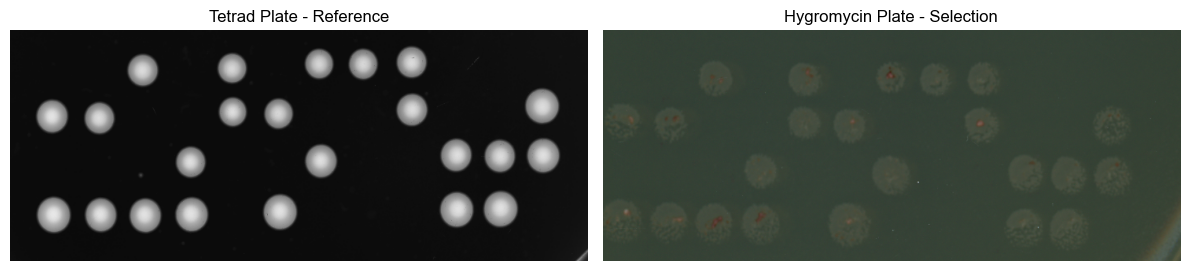

In [58]:
# ============================================================
# 2.1 Define Image Paths and Read
# ============================================================

# 示例图像路径 (Non-Essential Gene 案例)
TETRAD_PATH = "/hugedata/YushengYang/DIT_HAP_verification/data/cropped_images/DIT_HAP_deletion/17th_round/6d/242_tyw3_6d_#1_202510.cropped.png"
HYG_PATH = "/hugedata/YushengYang/DIT_HAP_verification/data/cropped_images/DIT_HAP_deletion/17th_round/replica/242_tyw3_HYG_#1_202510.cropped.png"

tetrad_plate = io.imread(TETRAD_PATH)
hyg_plate = io.imread(HYG_PATH)

print("✅ Images loaded successfully!")
print(f"\n📊 Image info:")
print(f"   Tetrad plate: {tetrad_plate.shape} | dtype: {tetrad_plate.dtype}")
print(f"   HYG plate:    {hyg_plate.shape} | dtype: {hyg_plate.dtype}")

# Display original images
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(tetrad_plate)
axes[0].set_title('Tetrad Plate - Reference')
axes[0].axis('off')

axes[1].imshow(hyg_plate)
axes[1].set_title('Hygromycin Plate - Selection')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Save copies for later use
tetrad_original = tetrad_plate.copy()
hyg_original = hyg_plate.copy()
sample_plate = tetrad_plate.copy()

---
## 第三章：灰度转换

### 3.1 为什么需要灰度图？

图像分割算法通常需要**单通道（灰度）输入**，而彩色图像有 3 个通道 (RGB)。

### 3.2 常用的灰度转换方法

| 方法 | 公式 | 适用场景 |
|------|------|----------|
| **取平均值** | $\text{gray} = \frac{R + G + B}{3}$ | 一般场景 |
| **加权平均** | $\text{gray} = 0.299R + 0.587G + 0.114B$ | 模拟人眼感知 |
| **取单通道** | $\text{gray} = R$ 或 $G$ 或 $B$ | 特定颜色背景 |

### 3.3 针对不同平板的策略

- **Tetrad 平板 (黑底)**: 使用 `np.mean(img, axis=2)` 取平均值
- **HYG 平板 (绿底)**: 使用 `img[:, :, 0]` 取红色通道
  - 原因：绿色背景在红色通道中呈现为**暗色**，而白色菌落保持**亮色**，对比度更高

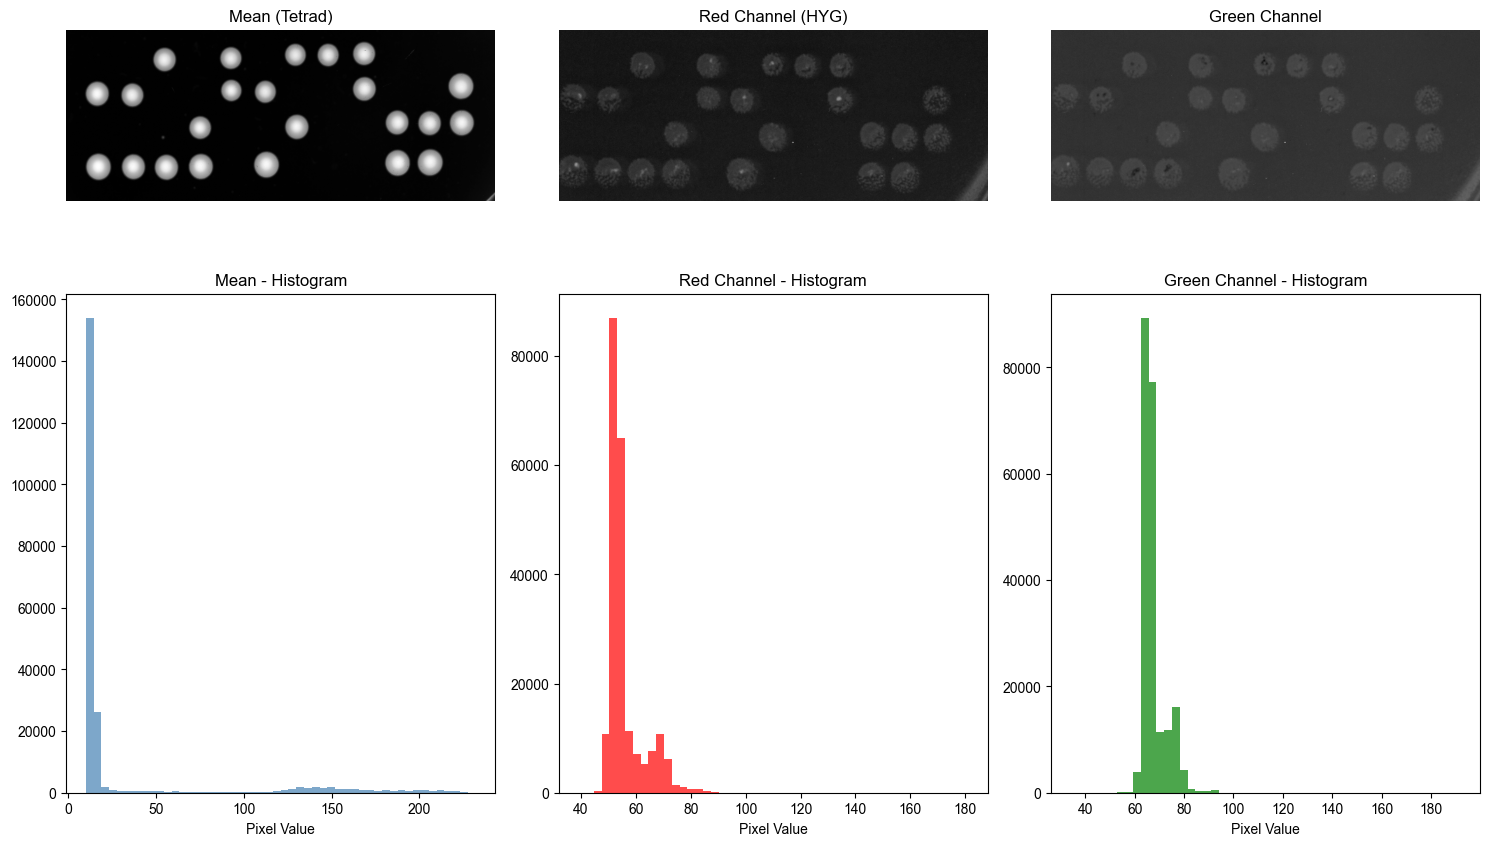

📝 Summary:
   Tetrad plate: np.mean() - Extract average brightness of all channels
   HYG plate:    Red channel - White colonies have high red values on green background



In [59]:
# ============================================================
# 3.1 Grayscale Conversion Methods Comparison
# ============================================================

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Method 1: Mean - Recommended for Tetrad
gray_mean = np.mean(tetrad_plate, axis=2)
axes[0, 0].imshow(gray_mean, cmap='gray')
axes[0, 0].set_title('Mean (Tetrad)')
axes[0, 0].axis('off')

# Method 2: Red channel - Recommended for HYG
gray_red = hyg_plate[:, :, 0].astype(float)
axes[0, 1].imshow(gray_red, cmap='gray')
axes[0, 1].set_title('Red Channel (HYG)')
axes[0, 1].axis('off')

# Method 3: Green channel
gray_green = hyg_plate[:, :, 1].astype(float)
axes[0, 2].imshow(gray_green, cmap='gray')
axes[0, 2].set_title('Green Channel')
axes[0, 2].axis('off')

# Histogram comparison
axes[1, 0].hist(gray_mean.ravel(), bins=50, color='steelblue', alpha=0.7)
axes[1, 0].set_title('Mean - Histogram')
axes[1, 0].set_xlabel('Pixel Value')

axes[1, 1].hist(gray_red.ravel(), bins=50, color='red', alpha=0.7)
axes[1, 1].set_title('Red Channel - Histogram')
axes[1, 1].set_xlabel('Pixel Value')

axes[1, 2].hist(gray_green.ravel(), bins=50, color='green', alpha=0.7)
axes[1, 2].set_title('Green Channel - Histogram')
axes[1, 2].set_xlabel('Pixel Value')

plt.tight_layout()
plt.show()

print("""📝 Summary:
   Tetrad plate: np.mean() - Extract average brightness of all channels
   HYG plate:    Red channel - White colonies have high red values on green background
""")

---
## 第四章：高斯模糊

### 4.1 为什么需要模糊？

高斯模糊是一种**低通滤波器**，主要作用：
- 🔇 **减少噪声** — 平滑图像中的随机噪点
- 🌫️ **去除细节** — 忽略不重要的纹理
- 📈 **改善分割** — 使二值化结果更加平滑

### 4.2 高斯核公式

$$G(x,y) = \frac{1}{2\pi\sigma^2} \exp\left(-\frac{x^2+y^2}{2\sigma^2}\right)$$

其中 $\sigma$ (sigma) 是**标准差**，控制模糊程度：

| σ 值 | 效果 | 适用场景 |
|------|------|----------|
| 0.5 - 1.0 | 轻微模糊 | HYG 平板，保留细节 |
| 1.0 - 2.0 | 中等模糊 | Tetrad 平板 |
| 2.0+ | 强模糊 | 噪声严重的图像 |

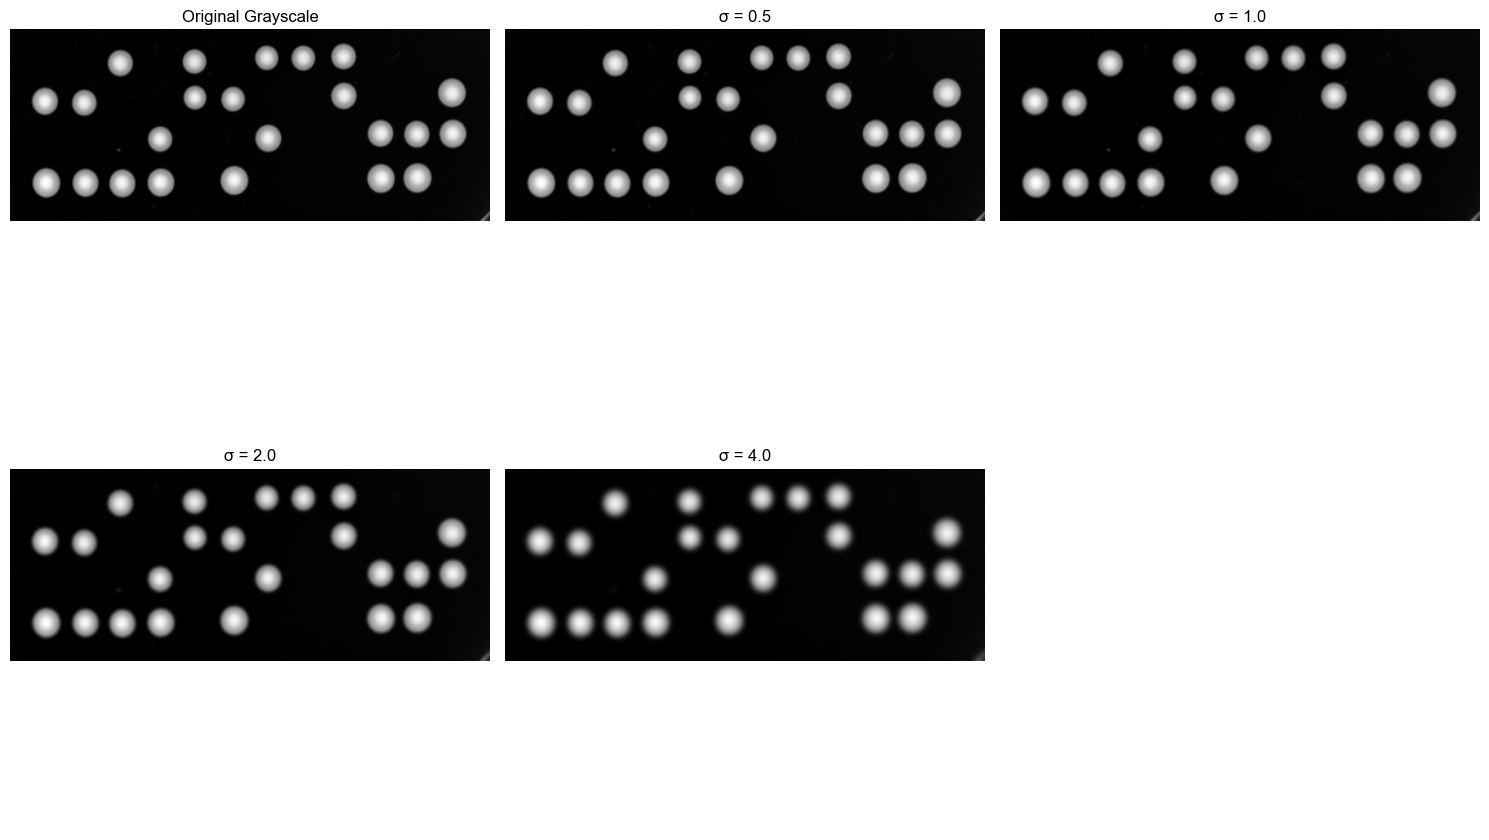

📝 Recommended parameters:
   Tetrad plate: sigma = 1.0 ~ 2.0 (larger colonies)
   HYG plate:    sigma = 0.5 ~ 1.0 (smaller colonies)



In [60]:
# ============================================================
# 4.1 Gaussian Blur Effect Comparison
# ============================================================

# Using grayscale of Tetrad plate
gray = np.mean(tetrad_plate, axis=2)

# Test different sigma values
sigmas = [0.5, 1.0, 2.0, 4.0]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Original image
axes[0, 0].imshow(gray, cmap='gray')
axes[0, 0].set_title('Original Grayscale')
axes[0, 0].axis('off')

# Different sigma values
for i, sigma in enumerate(sigmas):
    blurred = gaussian(gray, sigma=sigma, preserve_range=True)
    ax = axes[(i+1)//3, (i+1)%3]
    ax.imshow(blurred, cmap='gray')
    ax.set_title(f'σ = {sigma}')
    ax.axis('off')

axes[1, 2].axis('off')
plt.tight_layout()
plt.show()

print("""📝 Recommended parameters:
   Tetrad plate: sigma = 1.0 ~ 2.0 (larger colonies)
   HYG plate:    sigma = 0.5 ~ 1.0 (smaller colonies)
""")

---
## 第五章：阈值分割 (Otsu 方法)

### 5.1 什么是阈值分割？

将灰度图转换为**二值图** (Binary Image):
- 像素值 > 阈值 → **白色** (前景/菌落)
- 像素值 ≤ 阈值 → **黑色** (背景)

### 5.2 Otsu 方法原理

Otsu 方法**自动计算**最佳阈值，通过最大化**类间方差**：

$$\sigma_B^2(t) = \omega_0(t) \cdot \omega_1(t) \cdot [\mu_0(t) - \mu_1(t)]^2$$

其中：
- $\omega_0, \omega_1$ 是两类的像素比例
- $\mu_0, \mu_1$ 是两类的平均灰度值

### 5.3 优点与限制

✅ **优点**: 自动计算，无需手动调参  
⚠️ **限制**: 对双峰直方图效果最好；单峰图像可能失效

✅ Otsu automatic threshold: 84.9


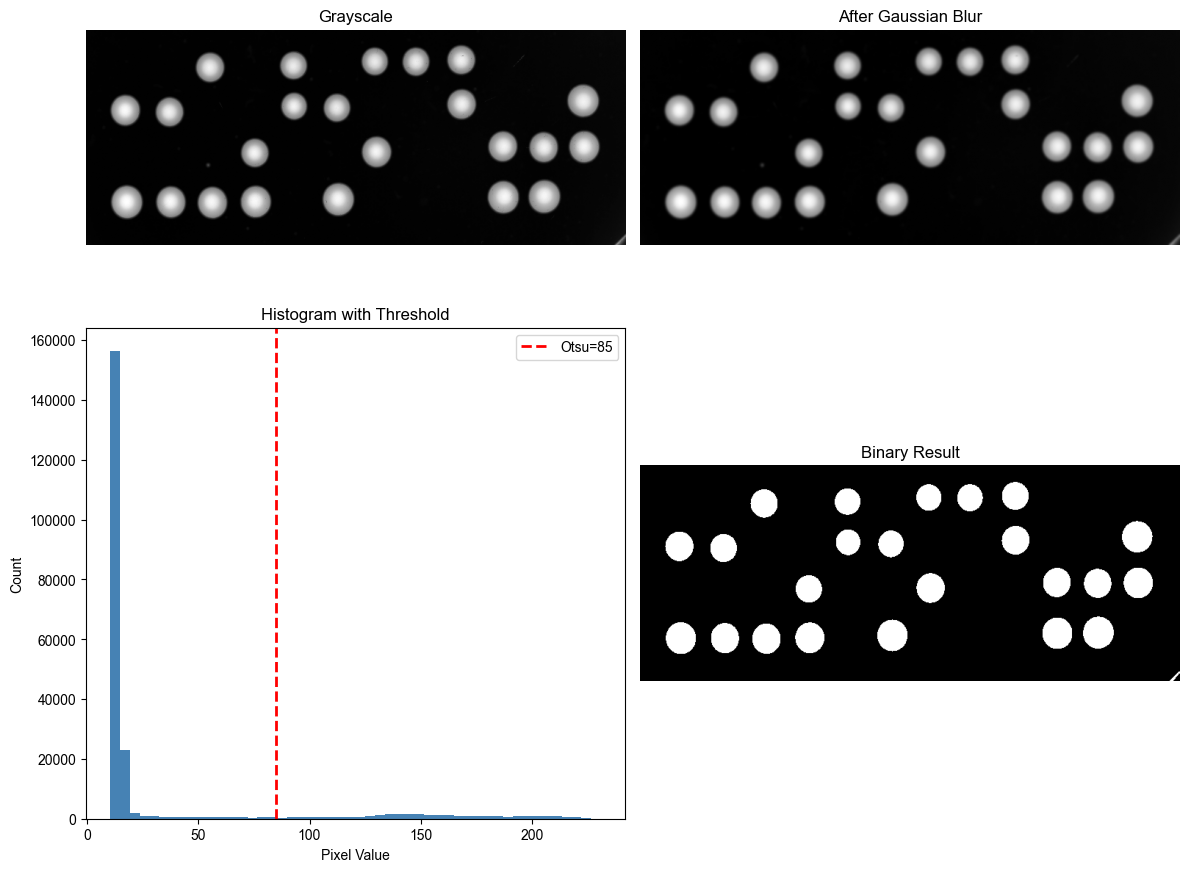

In [61]:
# ============================================================
# 5.1 Otsu Threshold Segmentation Demonstration
# ============================================================

# Preprocessing: Grayscale + Gaussian blur
gray = np.mean(tetrad_plate, axis=2)
blurred = gaussian(gray, sigma=1.0, preserve_range=True)

# Otsu threshold calculation
threshold = threshold_otsu(blurred)
binary_mask = blurred > threshold

print(f"✅ Otsu automatic threshold: {threshold:.1f}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].imshow(gray, cmap='gray')
axes[0, 0].set_title('Grayscale')
axes[0, 0].axis('off')

axes[0, 1].imshow(blurred, cmap='gray')
axes[0, 1].set_title('After Gaussian Blur')
axes[0, 1].axis('off')

axes[1, 0].hist(blurred.ravel(), bins=50, color='steelblue')
axes[1, 0].axvline(threshold, color='red', linestyle='--', linewidth=2, 
                   label=f'Otsu={threshold:.0f}')
axes[1, 0].set_xlabel('Pixel Value')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Histogram with Threshold')
axes[1, 0].legend()

axes[1, 1].imshow(binary_mask, cmap='gray')
axes[1, 1].set_title('Binary Result')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

---
## 第六章：形态学操作

### 6.1 为什么需要形态学操作？

二值化后的图像可能存在：
- 🔴 **噪点** — 小的白色斑点 (假阳性)
- ⚫ **孔洞** — 菌落内部的黑色空洞

形态学操作可以有效清理这些问题。

### 6.2 基本操作

| 操作 | 英文名 | 效果 | 用途 |
|------|--------|------|------|
| **腐蚀** | Erosion | 缩小白色区域 | 去除边缘 |
| **膨胀** | Dilation | 扩大白色区域 | 填充空隙 |
| **开运算** | Opening | 腐蚀 → 膨胀 | 🎯 **去除噪点** |
| **闭运算** | Closing | 膨胀 → 腐蚀 | 填充孔洞 |

### 6.3 结构元素 (Structuring Element)

定义操作的"形状"和"强度"：
- `morphology.disk(r)` — 圆形，半径 r
- `morphology.square(n)` — 方形，边长 n

> **💡 推荐**: 使用 `disk(3)` 进行开运算，可有效去除噪点同时保持菌落形状。

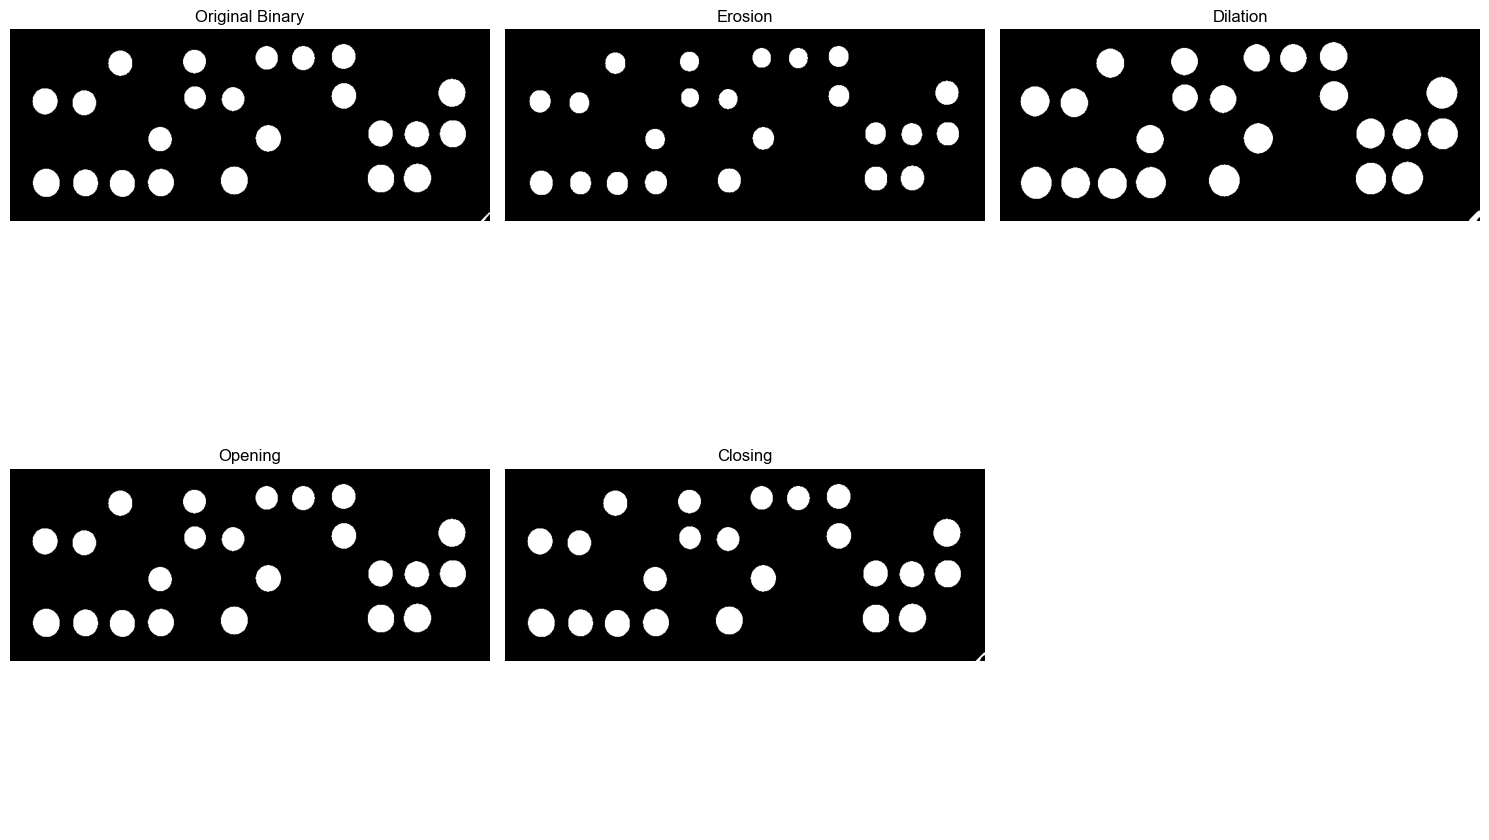

📝 Applications in colony detection:
   Opening: Remove small noise while preserving colony shape ← Recommended!
   Closing: Fill internal holes in colonies



In [62]:
# ============================================================
# 6.1 Morphological Operations Effect Comparison
# ============================================================

# Create structuring element
selem = morphology.disk(3)  # Disk with radius 3

# Apply various morphological operations
eroded = morphology.binary_erosion(binary_mask, selem)
dilated = morphology.binary_dilation(binary_mask, selem)
opened = morphology.binary_opening(binary_mask, selem)
closed = morphology.binary_closing(binary_mask, selem)

operations = [
    (binary_mask, 'Original Binary'),
    (eroded, 'Erosion'),
    (dilated, 'Dilation'),
    (opened, 'Opening'),
    (closed, 'Closing')
]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (img, title) in enumerate(operations):
    axes[idx].imshow(img, cmap='gray')
    axes[idx].set_title(title)
    axes[idx].axis('off')

axes[5].axis('off')
plt.tight_layout()
plt.show()

print("""📝 Applications in colony detection:
   Opening: Remove small noise while preserving colony shape ← Recommended!
   Closing: Fill internal holes in colonies
""")

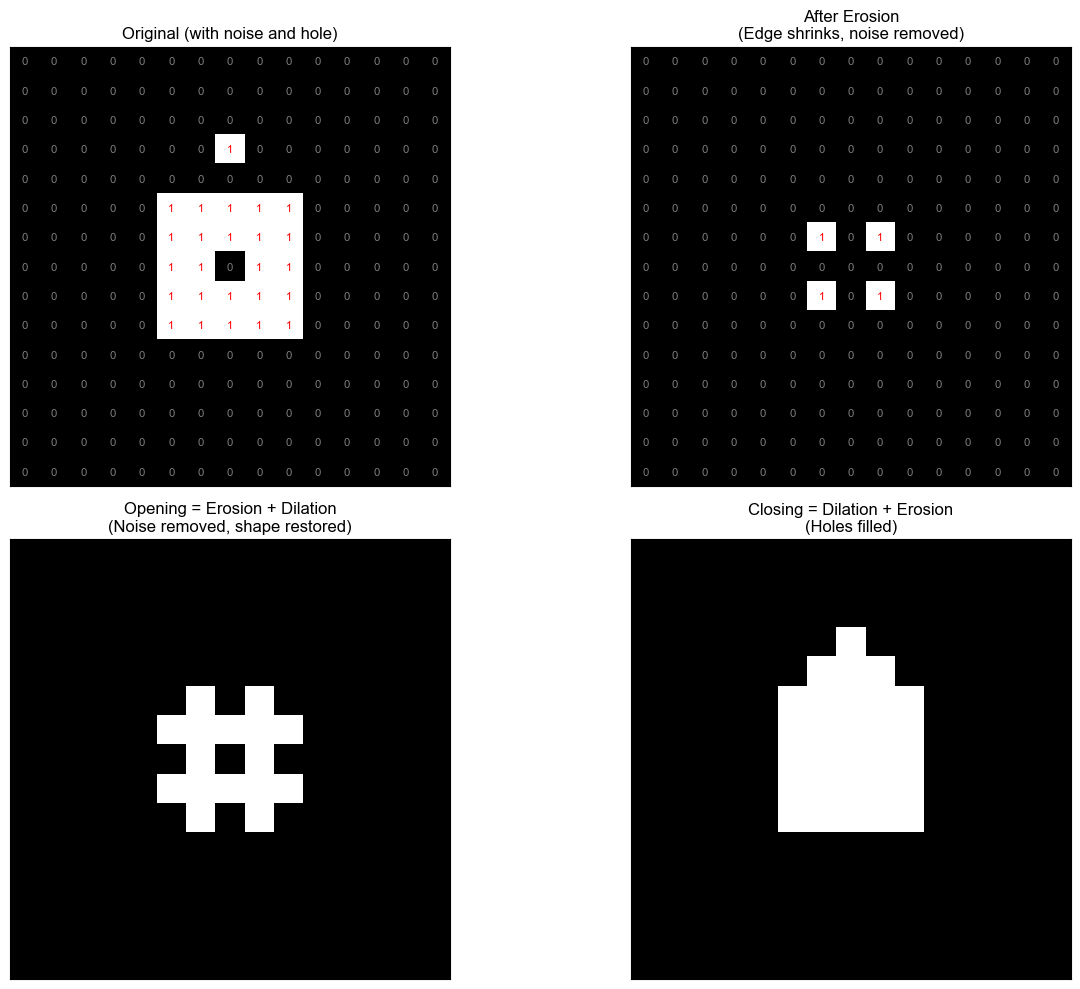

In [63]:
# ============================================================
# 6.2 Morphological Operations Principle Illustration
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Create demonstration image
demo_size = 15
demo_img = np.zeros((demo_size, demo_size), dtype=np.uint8)
demo_img[5:10, 5:10] = 1  # Main region
demo_img[3, 7] = 1  # Isolated noise point
demo_img[7, 7] = 0  # Internal hole
selem_small = morphology.disk(1)

# Erosion and Dilation basic principle
axes[0, 0].imshow(demo_img, cmap='gray')
axes[0, 0].set_title('Original (with noise and hole)')
for i in range(demo_size):
    for j in range(demo_size):
        axes[0, 0].text(j, i, int(demo_img[i, j]), ha='center', va='center', 
                        fontsize=8, color='red' if demo_img[i, j] else 'gray')
axes[0, 0].set_xticks([])
axes[0, 0].set_yticks([])

demo_eroded = morphology.binary_erosion(demo_img, selem_small)
axes[0, 1].imshow(demo_eroded, cmap='gray')
axes[0, 1].set_title('After Erosion\n(Edge shrinks, noise removed)')
for i in range(demo_size):
    for j in range(demo_size):
        axes[0, 1].text(j, i, int(demo_eroded[i, j]), ha='center', va='center', 
                        fontsize=8, color='red' if demo_eroded[i, j] else 'gray')
axes[0, 1].set_xticks([])
axes[0, 1].set_yticks([])

# Opening removes noise
demo_opened = morphology.binary_opening(demo_img, selem_small)
axes[1, 0].imshow(demo_opened, cmap='gray')
axes[1, 0].set_title('Opening = Erosion + Dilation\n(Noise removed, shape restored)')
axes[1, 0].set_xticks([])
axes[1, 0].set_yticks([])

# Closing fills holes
demo_with_hole = demo_img.copy()
demo_with_hole[7, 7] = 0
demo_closed = morphology.binary_closing(demo_with_hole, selem_small)
axes[1, 1].imshow(demo_closed, cmap='gray')
axes[1, 1].set_title('Closing = Dilation + Erosion\n(Holes filled)')
axes[1, 1].set_xticks([])
axes[1, 1].set_yticks([])

plt.tight_layout()
plt.show()

HYG plate Otsu threshold: 61.0


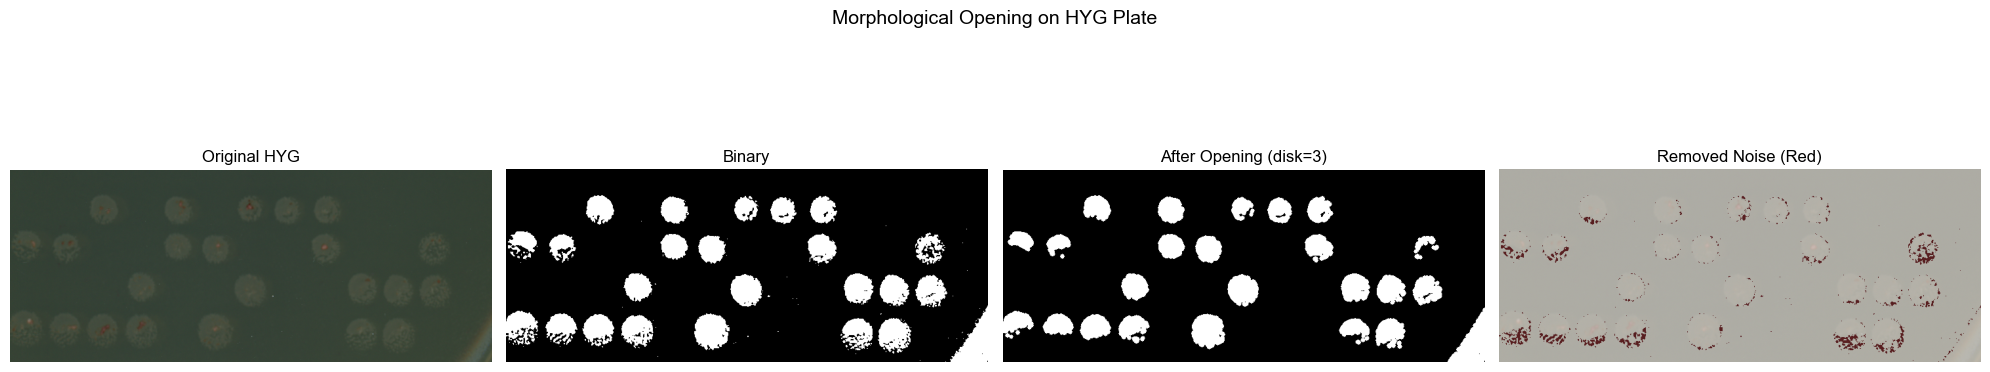


📊 Statistics:
   Original white pixels: 35,344
   After cleaning: 31,156
   Removed noise: 4,188 (11.8%)


In [64]:
# ============================================================
# 6.3 Morphological Opening Effect on Real HYG Image
# ============================================================

# HYG plate processing: Use red channel
gray_hyg = hyg_plate[:, :, 0].astype(float)
blurred_hyg = gaussian(gray_hyg, sigma=0.5, preserve_range=True)
thresh_hyg = threshold_otsu(blurred_hyg)
binary_hyg = blurred_hyg > thresh_hyg

print(f"HYG plate Otsu threshold: {thresh_hyg:.1f}")

# Apply morphological operations
opened_hyg_3 = morphology.binary_opening(binary_hyg, morphology.disk(3))

# Visualization: Overlay comparison
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

axes[0].imshow(hyg_plate)
axes[0].set_title('Original HYG')
axes[0].axis('off')

axes[1].imshow(binary_hyg, cmap='gray')
axes[1].set_title('Binary')
axes[1].axis('off')

axes[2].imshow(opened_hyg_3, cmap='gray')
axes[2].set_title('After Opening (disk=3)')
axes[2].axis('off')

# Difference comparison: Removed noise
diff = binary_hyg.astype(int) - opened_hyg_3.astype(int)
axes[3].imshow(hyg_plate)
axes[3].imshow(diff == 1, alpha=0.6, cmap='Reds')
axes[3].set_title('Removed Noise (Red)')
axes[3].axis('off')

plt.suptitle('Morphological Opening on HYG Plate', fontsize=14)
plt.tight_layout()
plt.show()

# Statistics
removed_pixels = np.sum(binary_hyg) - np.sum(opened_hyg_3)
print(f"\n📊 Statistics:")
print(f"   Original white pixels: {np.sum(binary_hyg):,}")
print(f"   After cleaning: {np.sum(opened_hyg_3):,}")
print(f"   Removed noise: {removed_pixels:,} ({removed_pixels/np.sum(binary_hyg)*100:.1f}%)")

---
## 第七章：分水岭分割

### 7.1 问题：融合的菌落

当两个菌落靠得很近时，二值化会把它们**合并成一个区域**，导致无法分别计数。

### 7.2 分水岭算法原理

想象图像是一个**地形图**：
1. 将灰度值（距离变换后）视为「海拔高度」
2. 从局部最低点（背景边缘）开始「注水」
3. 水位上升直到不同流域相遇
4. 相遇处形成「分水岭」—— 即菌落边界

### 7.3 实现步骤

```python
# Step 1: 距离变换 - 计算每个前景像素到最近背景的距离
distance_map = ndimage.distance_transform_edt(binary_mask)

# Step 2: 找局部最大值作为种子点
coords = peak_local_max(distance_map, min_distance=20)

# Step 3: 应用分水岭分割
labels = watershed(-distance_map, markers, mask=binary_mask)
```

✅ Found 2 local maxima (colony centers)


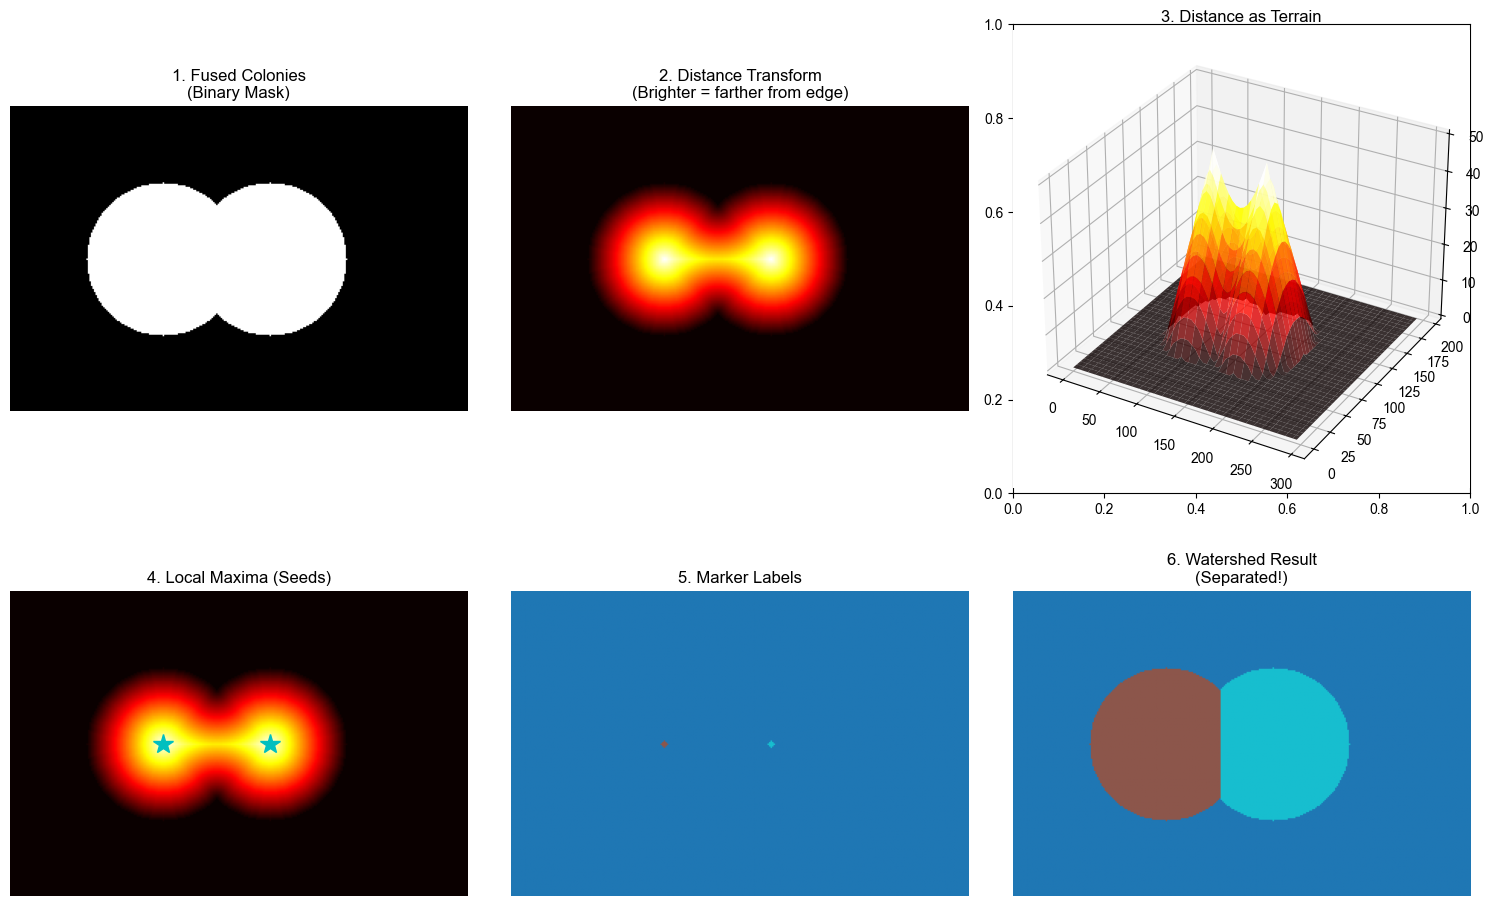


📝 Key parameters:
   min_distance: Minimum distance between two seed points
   • Tetrad plate: min_distance=20
   • HYG plate: min_distance=5 (smaller colonies)



In [65]:
# ============================================================
# 7. Watershed Algorithm Demonstration
# ============================================================

# Create two fused circles (simulating fused colonies)
def create_fused_colonies():
    img = np.zeros((200, 300), dtype=np.uint8)
    cv2.circle(img, (100, 100), 50, 255, -1)
    cv2.circle(img, (170, 100), 50, 255, -1)
    return img > 0

fused_mask = create_fused_colonies()

# Step 1: Distance transform
distance_map = ndimage.distance_transform_edt(fused_mask)

# Step 2: Find local maxima
coords = peak_local_max(distance_map, min_distance=20, labels=fused_mask.astype(int))
print(f"✅ Found {len(coords)} local maxima (colony centers)")

# Create markers
markers = np.zeros(distance_map.shape, dtype=int)
markers[tuple(coords.T)] = np.arange(1, len(coords) + 1)
markers = morphology.binary_dilation(markers > 0, morphology.disk(2))
markers = measure.label(markers)

# Step 3: Watershed segmentation
ws_labels = watershed(-distance_map, markers, mask=fused_mask)

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].imshow(fused_mask, cmap='gray')
axes[0, 0].set_title('1. Fused Colonies\n(Binary Mask)')
axes[0, 0].axis('off')

axes[0, 1].imshow(distance_map, cmap='hot')
axes[0, 1].set_title('2. Distance Transform\n(Brighter = farther from edge)')
axes[0, 1].axis('off')

# 3D visualization
from mpl_toolkits.mplot3d import Axes3D
ax3d = fig.add_subplot(2, 3, 3, projection='3d')
X, Y = np.meshgrid(range(distance_map.shape[1]), range(distance_map.shape[0]))
ax3d.plot_surface(X[::5, ::5], Y[::5, ::5], distance_map[::5, ::5], cmap='hot', alpha=0.8)
ax3d.set_title('3. Distance as Terrain')

axes[1, 0].imshow(distance_map, cmap='hot')
for i, (y, x) in enumerate(coords):
    axes[1, 0].plot(x, y, 'c*', markersize=15)
axes[1, 0].set_title('4. Local Maxima (Seeds)')
axes[1, 0].axis('off')

axes[1, 1].imshow(markers, cmap='tab10')
axes[1, 1].set_title('5. Marker Labels')
axes[1, 1].axis('off')

axes[1, 2].imshow(ws_labels, cmap='tab10')
axes[1, 2].set_title('6. Watershed Result\n(Separated!)')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

print("""
📝 Key parameters:
   min_distance: Minimum distance between two seed points
   • Tetrad plate: min_distance=20
   • HYG plate: min_distance=5 (smaller colonies)
""")

---
## 第八章：区域属性与质心提取

### 8.1 连通区域标记

`measure.label()` 将二值图中的**连通区域**标记为不同整数：
- 背景 = 0
- 区域1 = 1, 区域2 = 2, ...

### 8.2 区域属性 (regionprops)

`measure.regionprops()` 计算每个区域的属性：

| 属性 | 说明 | 用途 |
|------|------|------|
| `area` | 面积 (像素数) | 过滤噪点 |
| `centroid` | 质心坐标 (y, x) | 定位菌落 |
| `bbox` | 边界框 | 裁剪区域 |
| `eccentricity` | 离心率 | 判断形状 |

> ⚠️ **注意**: `centroid` 返回的是 `(row, col)` = `(y, x)`，与图像坐标 `(x, y)` 相反！

✅ Detected 23 connected regions
   After filtering: 23 colonies retained (area > 10)


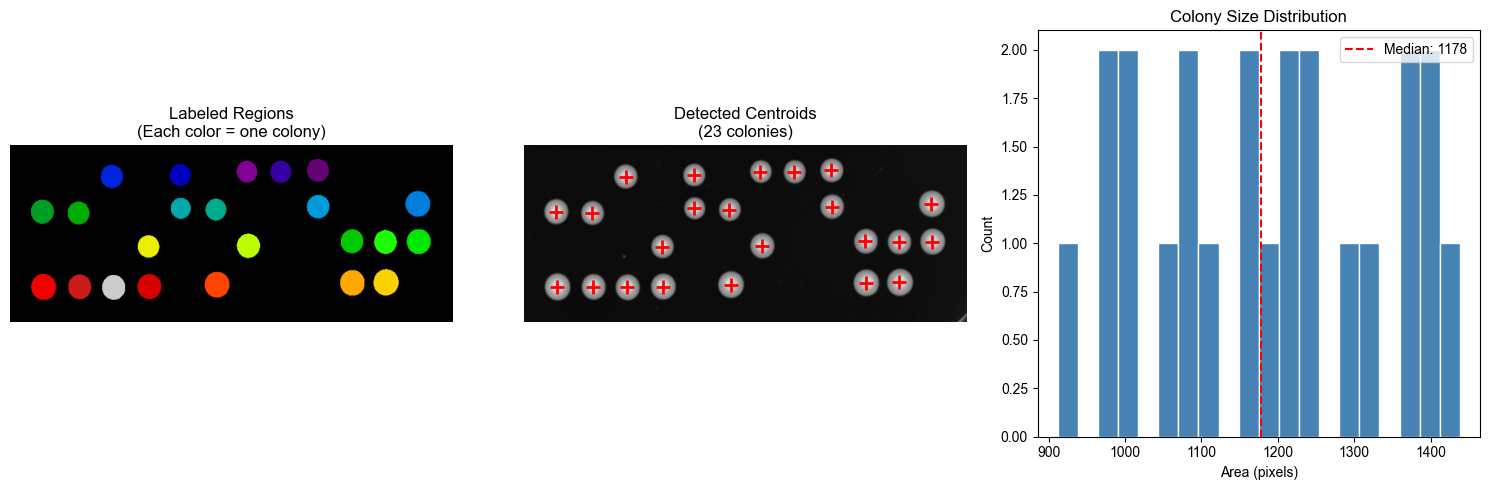

In [66]:
# ============================================================
# 8. Region Properties Extraction
# ============================================================

# Using Tetrad plate
cleaned_mask = morphology.binary_opening(binary_mask, morphology.disk(3))

# Label connected regions
label_img = measure.label(cleaned_mask)
print(f"✅ Detected {label_img.max()} connected regions")

# Calculate region properties
props = measure.regionprops(label_img)

# Extract centroids (filter regions with area > 10)
min_area = 10
centroids = []
areas = []

for prop in props:
    if prop.area > min_area:
        y, x = prop.centroid  # Note: (row, col) = (y, x)
        centroids.append((x, y))
        areas.append(prop.area)

print(f"   After filtering: {len(centroids)} colonies retained (area > {min_area})")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Label map
axes[0].imshow(label_img, cmap='nipy_spectral')
axes[0].set_title('Labeled Regions\n(Each color = one colony)')
axes[0].axis('off')

# Centroid markers
axes[1].imshow(tetrad_plate)
for (x, y) in centroids:
    axes[1].plot(x, y, 'r+', markersize=10, markeredgewidth=2)
axes[1].set_title(f'Detected Centroids\n({len(centroids)} colonies)')
axes[1].axis('off')

# Area distribution
if areas:
    axes[2].hist(areas, bins=20, color='steelblue', edgecolor='white')
    axes[2].axvline(np.median(areas), color='red', linestyle='--', 
                    label=f'Median: {np.median(areas):.0f}')
    axes[2].set_xlabel('Area (pixels)')
    axes[2].set_ylabel('Count')
    axes[2].set_title('Colony Size Distribution')
    axes[2].legend()

plt.tight_layout()
plt.show()

---
## 第九章：图像对齐

### 9.1 为什么需要对齐？

转印过程中，两张图片可能存在：
- 📐 **平移** (Translation) — 位置偏移
- 🔄 **旋转** (Rotation) — 角度偏差
- 📏 **缩放** (Scale) — 大小差异

### 9.2 仿射变换

仿射变换可以同时处理平移、旋转和缩放：

$$\begin{bmatrix} x' \\ y' \end{bmatrix} = \begin{bmatrix} a & b \\ c & d \end{bmatrix} \begin{bmatrix} x \\ y \end{bmatrix} + \begin{bmatrix} t_x \\ t_y \end{bmatrix}$$

OpenCV 使用 2×3 矩阵: $M = \begin{bmatrix} a & b & t_x \\ c & d & t_y \end{bmatrix}$

### 9.3 对齐流程

1. **检测菌落** — 在两张图上分别检测质心
2. **匈牙利匹配** — 找到最优的点对匹配
3. **RANSAC 估计** — 鲁棒地计算变换矩阵
4. **应用变换** — `cv2.warpAffine()` 对齐图像

✅ Tetrad: 23 colonies
   HYG:    27 colonies
   Matched: 23 pairs

📊 Estimated Transform:
   Scale: 1.0021
   Rotation: -1.96°
   Translation: (23.6, -3.5) px


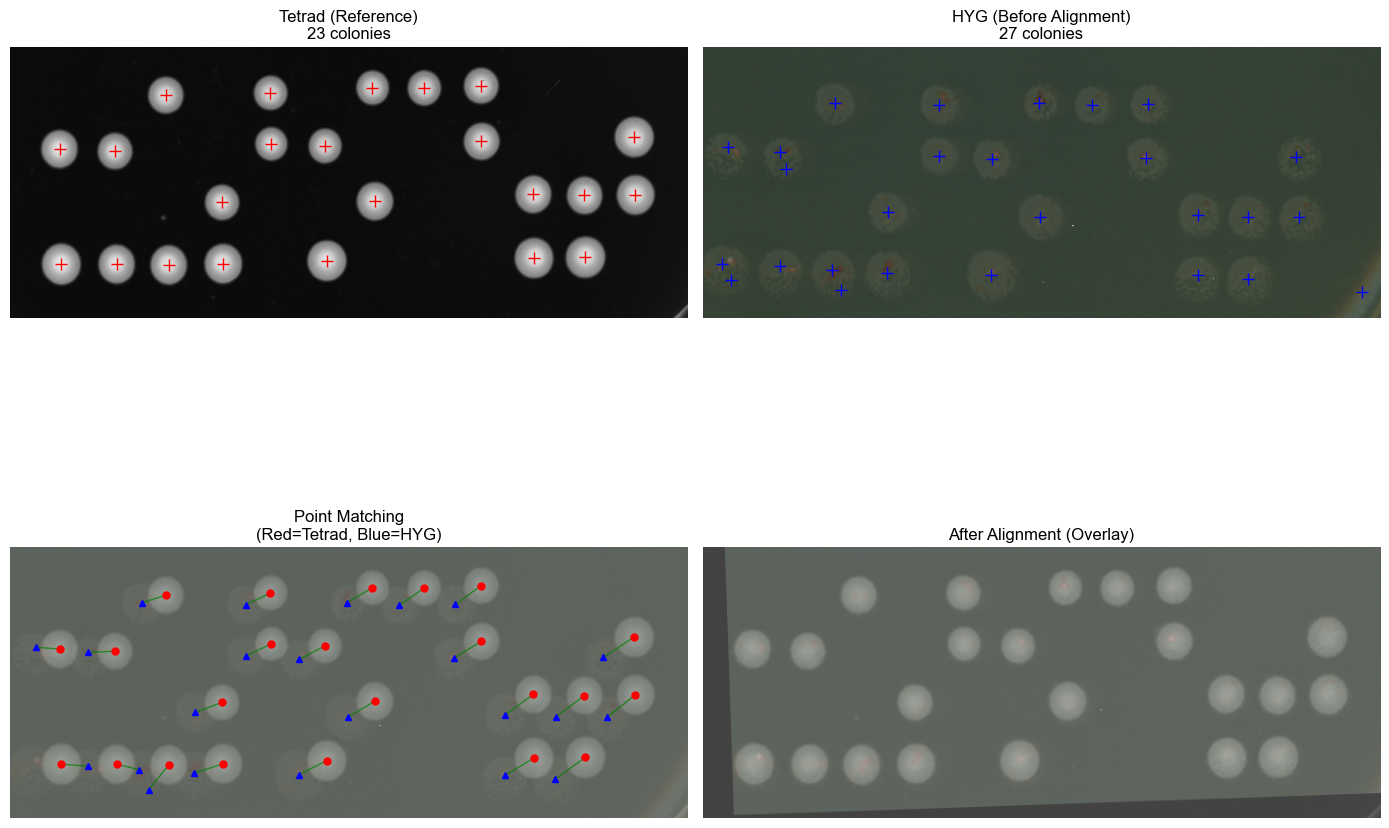

In [67]:
# ============================================================
# 9. Image Alignment Demonstration
# ============================================================

# Simplified colony detection function
def detect_colonies_simple(img, is_hyg=False, min_area=20):
    """Detect colony centroids"""
    if is_hyg:
        gray = img[:, :, 0].astype(float)  # HYG: Red channel
    else:
        gray = np.mean(img, axis=2)  # Tetrad: Mean value
    
    blurred = gaussian(gray, sigma=1.0, preserve_range=True)
    
    try:
        thresh = threshold_otsu(blurred)
        binary = blurred > thresh
    except:
        binary = blurred > 100
    
    binary = morphology.binary_opening(binary, morphology.disk(3))
    label_img = measure.label(binary)
    props = measure.regionprops(label_img)
    
    centroids = [(p.centroid[1], p.centroid[0]) for p in props if p.area > min_area]
    return centroids, binary

# Resize HYG to match Tetrad
h_ref, w_ref = tetrad_plate.shape[:2]
hyg_resized = cv2.resize(hyg_plate, (w_ref, h_ref))

# Detect colonies
centroids_tetrad, mask_tetrad = detect_colonies_simple(tetrad_plate, is_hyg=False)
centroids_hyg, mask_hyg = detect_colonies_simple(hyg_resized, is_hyg=True)

print(f"✅ Tetrad: {len(centroids_tetrad)} colonies")
print(f"   HYG:    {len(centroids_hyg)} colonies")

# Hungarian algorithm matching
hyg_aligned = hyg_resized  # Default
M_estimated = None

if len(centroids_tetrad) >= 3 and len(centroids_hyg) >= 3:
    pts_tetrad = np.array(centroids_tetrad, dtype=np.float32)
    pts_hyg = np.array(centroids_hyg, dtype=np.float32)
    
    dist_matrix = distance.cdist(pts_tetrad, pts_hyg)
    row_ind, col_ind = linear_sum_assignment(dist_matrix)
    
    # Filter matches with large distance
    max_dist = max(h_ref, w_ref) * 0.15
    matched_tetrad, matched_hyg = [], []
    
    for r, c in zip(row_ind, col_ind):
        if dist_matrix[r, c] < max_dist:
            matched_tetrad.append(pts_tetrad[r])
            matched_hyg.append(pts_hyg[c])
    
    print(f"   Matched: {len(matched_tetrad)} pairs")
    
    if len(matched_tetrad) >= 3:
        matched_tetrad = np.array(matched_tetrad, dtype=np.float32)
        matched_hyg = np.array(matched_hyg, dtype=np.float32)
        
        # RANSAC transform estimation
        M_estimated, inliers = cv2.estimateAffinePartial2D(
            matched_hyg, matched_tetrad, method=cv2.RANSAC, ransacReprojThreshold=5.0
        )
        
        hyg_aligned = cv2.warpAffine(hyg_resized, M_estimated, (w_ref, h_ref))
        
        # Extract transform parameters
        scale = np.sqrt(M_estimated[0, 0]**2 + M_estimated[0, 1]**2)
        angle = np.degrees(np.arctan2(M_estimated[1, 0], M_estimated[0, 0]))
        tx, ty = M_estimated[0, 2], M_estimated[1, 2]
        
        print(f"\n📊 Estimated Transform:")
        print(f"   Scale: {scale:.4f}")
        print(f"   Rotation: {angle:.2f}°")
        print(f"   Translation: ({tx:.1f}, {ty:.1f}) px")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

axes[0, 0].imshow(tetrad_plate)
for (x, y) in centroids_tetrad:
    axes[0, 0].plot(x, y, 'r+', markersize=8)
axes[0, 0].set_title(f'Tetrad (Reference)\n{len(centroids_tetrad)} colonies')
axes[0, 0].axis('off')

axes[0, 1].imshow(hyg_resized)
for (x, y) in centroids_hyg:
    axes[0, 1].plot(x, y, 'b+', markersize=8)
axes[0, 1].set_title(f'HYG (Before Alignment)\n{len(centroids_hyg)} colonies')
axes[0, 1].axis('off')

# Matching visualization
axes[1, 0].imshow(tetrad_plate, alpha=0.5)
axes[1, 0].imshow(hyg_resized, alpha=0.5)
if M_estimated is not None:
    for t, h in zip(matched_tetrad, matched_hyg):
        axes[1, 0].plot([t[0], h[0]], [t[1], h[1]], 'g-', linewidth=1, alpha=0.7)
        axes[1, 0].plot(t[0], t[1], 'ro', markersize=5)
        axes[1, 0].plot(h[0], h[1], 'b^', markersize=5)
axes[1, 0].set_title('Point Matching\n(Red=Tetrad, Blue=HYG)')
axes[1, 0].axis('off')

# Alignment result
axes[1, 1].imshow(tetrad_plate, alpha=0.5)
axes[1, 1].imshow(hyg_aligned, alpha=0.5)
axes[1, 1].set_title('After Alignment (Overlay)')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

---
## 第十章：网格拟合与旋转校正

### 10.1 基因型判断的两种方法

| 方法 | 原理 | 优点 | 缺点 |
|------|------|------|------|
| **距离匹配** | 比较 Tetrad 和 HYG 的菌落距离 | 简单直观 | 受 HYG 检测质量影响 |
| **网格信号** | 在 HYG 上固定位置测量信号 | 稳定可靠 | 需要准确的网格 |

### 10.2 网格拟合方法

对于 4 行 × 12 列的四分体平板：

1. **简单边界框** — 取所有质心的边界，均匀划分
2. **PCA 旋转校正** — 先检测旋转角度，再拟合网格
3. **优化方法** — 最小化网格点到质心的距离

### 10.3 PCA 旋转校正原理

当平板在扫描时存在轻微旋转，简单的边界框方法会产生偏差。PCA (主成分分析) 可以：

1. **检测旋转角度**: 第一主成分 (PC1) 方向即为菌落行的主方向
2. **计算旋转矩阵**: $R = \begin{bmatrix} \cos\theta & -\sin\theta \\ \sin\theta & \cos\theta \end{bmatrix}$
3. **校正步骤**:
   - 将质心旋转到水平/垂直对齐状态
   - 在对齐后的坐标系中拟合网格
   - 将网格旋转回原始坐标系

### 10.4 Essential Gene 的特殊情况

对于 **Essential Gene**，每个 tetrad 只有 **2 个存活孢子** (DEL 致死)，需要：
- 自动检测实际的行数
- 处理缺失位置

✅ Grid fitted:
   X spacing: 56.8 px
   Y spacing: 64.8 px

📊 Genotyping Result:
   Threshold: 55.6
   DEL (HYG-R): 24
   WT (HYG-S):  24


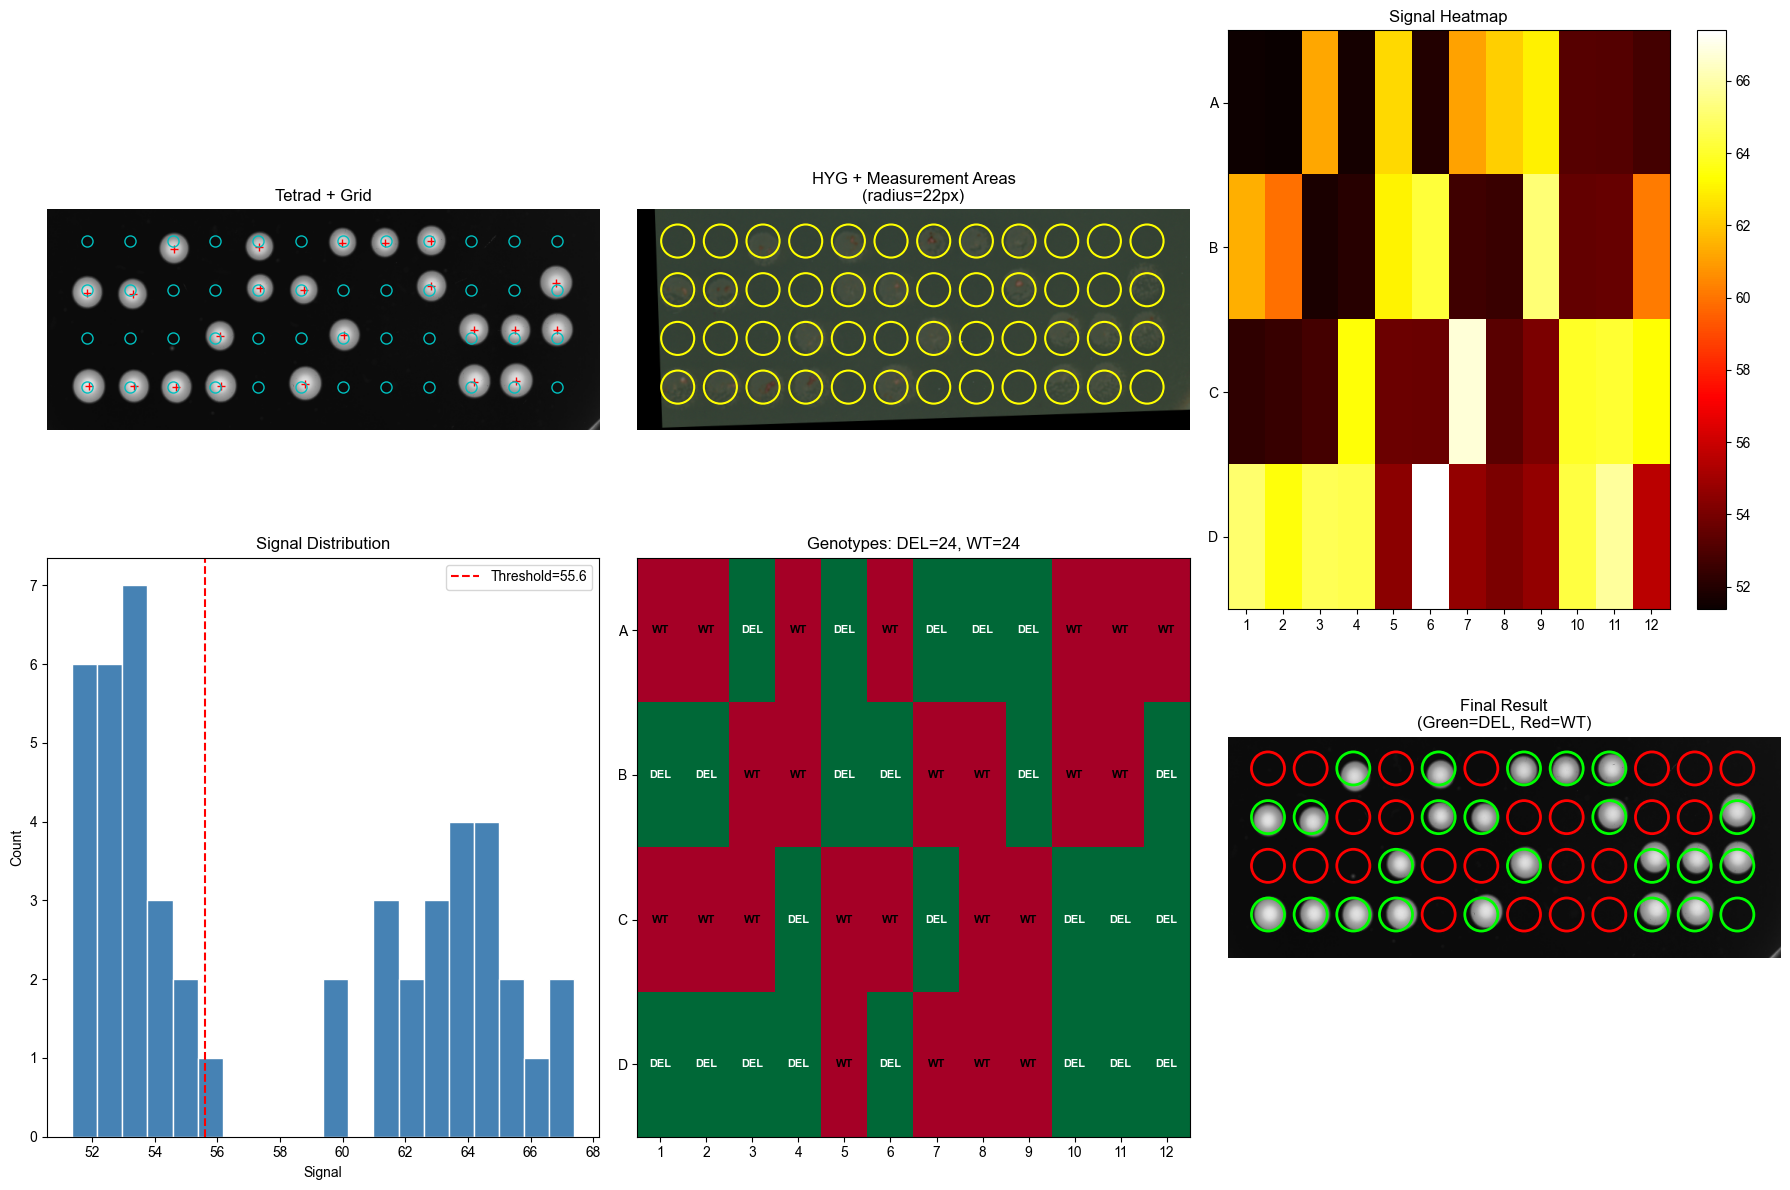

In [68]:
# ============================================================
# 10.1 Simple Grid Fitting
# ============================================================

def fit_grid_simple(centroids, n_rows=4, n_cols=12):
    """Fit grid from centroid bounding box"""
    pts = np.array(centroids)
    x_min, x_max = pts[:, 0].min(), pts[:, 0].max()
    y_min, y_max = pts[:, 1].min(), pts[:, 1].max()
    
    x_spacing = (x_max - x_min) / (n_cols - 1) if n_cols > 1 else 0
    y_spacing = (y_max - y_min) / (n_rows - 1) if n_rows > 1 else 0
    
    grid = np.zeros((n_rows, n_cols, 2))
    for row in range(n_rows):
        for col in range(n_cols):
            grid[row, col, 0] = x_min + col * x_spacing
            grid[row, col, 1] = y_min + row * y_spacing
    
    return grid, {'x_spacing': x_spacing, 'y_spacing': y_spacing}

# Fit grid
grid_centers, grid_params = fit_grid_simple(centroids_tetrad, n_rows=4, n_cols=12)

print(f"✅ Grid fitted:")
print(f"   X spacing: {grid_params['x_spacing']:.1f} px")
print(f"   Y spacing: {grid_params['y_spacing']:.1f} px")

# ============================================================
# 10.2 Measure HYG Signal at Grid Positions
# ============================================================

def measure_grid_signal(image, grid, radius=15):
    """Measure signal intensity at each grid position"""
    n_rows, n_cols = grid.shape[:2]
    h, w = image.shape[:2]
    
    # Use red channel (HYG green background)
    gray = image[:, :, 0].astype(float) if image.ndim == 3 else image.astype(float)
    
    signals = np.zeros((n_rows, n_cols))
    
    for row in range(n_rows):
        for col in range(n_cols):
            cx, cy = int(grid[row, col, 0]), int(grid[row, col, 1])
            
            x1, x2 = max(0, cx - radius), min(w, cx + radius + 1)
            y1, y2 = max(0, cy - radius), min(h, cy + radius + 1)
            
            if x2 > x1 and y2 > y1:
                signals[row, col] = np.mean(gray[y1:y2, x1:x2])
    
    return signals

# Measure signal
measure_radius = int(grid_params['y_spacing'] * 0.35)
signals = measure_grid_signal(hyg_aligned, grid_centers, radius=measure_radius)

# Otsu threshold for genotyping
threshold = threshold_otsu(signals.flatten())
genotypes = np.where(signals > threshold, 'DEL', 'WT')

del_count = np.sum(genotypes == 'DEL')
wt_count = np.sum(genotypes == 'WT')

print(f"\n📊 Genotyping Result:")
print(f"   Threshold: {threshold:.1f}")
print(f"   DEL (HYG-R): {del_count}")
print(f"   WT (HYG-S):  {wt_count}")

# Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Tetrad + grid
axes[0, 0].imshow(tetrad_plate)
for (x, y) in centroids_tetrad:
    axes[0, 0].plot(x, y, 'r+', markersize=6)
for row in range(4):
    for col in range(12):
        gx, gy = grid_centers[row, col]
        axes[0, 0].plot(gx, gy, 'co', markersize=8, fillstyle='none')
axes[0, 0].set_title('Tetrad + Grid')
axes[0, 0].axis('off')

# HYG + measurement areas
axes[0, 1].imshow(hyg_aligned)
for row in range(4):
    for col in range(12):
        gx, gy = grid_centers[row, col]
        circ = Circle((gx, gy), radius=measure_radius, color='yellow', fill=False, linewidth=1.5)
        axes[0, 1].add_patch(circ)
axes[0, 1].set_title(f'HYG + Measurement Areas\n(radius={measure_radius}px)')
axes[0, 1].axis('off')

# Signal heatmap
im = axes[0, 2].imshow(signals, cmap='hot', aspect='auto')
axes[0, 2].set_title('Signal Heatmap')
axes[0, 2].set_xticks(range(12))
axes[0, 2].set_yticks(range(4))
axes[0, 2].set_xticklabels([str(i+1) for i in range(12)])
axes[0, 2].set_yticklabels(['A', 'B', 'C', 'D'])
plt.colorbar(im, ax=axes[0, 2])

# Signal distribution
axes[1, 0].hist(signals.flatten(), bins=20, color='steelblue', edgecolor='white')
axes[1, 0].axvline(threshold, color='red', linestyle='--', label=f'Threshold={threshold:.1f}')
axes[1, 0].set_xlabel('Signal')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Signal Distribution')
axes[1, 0].legend()

# Genotype table
gt_colors = np.where(genotypes == 'DEL', 1, 0)
axes[1, 1].imshow(gt_colors, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
for row in range(4):
    for col in range(12):
        color = 'white' if genotypes[row, col] == 'DEL' else 'black'
        axes[1, 1].text(col, row, genotypes[row, col], ha='center', va='center', 
                       fontsize=8, color=color, fontweight='bold')
axes[1, 1].set_title(f'Genotypes: DEL={del_count}, WT={wt_count}')
axes[1, 1].set_xticks(range(12))
axes[1, 1].set_yticks(range(4))
axes[1, 1].set_xticklabels([str(i+1) for i in range(12)])
axes[1, 1].set_yticklabels(['A', 'B', 'C', 'D'])

# Final result
axes[1, 2].imshow(tetrad_plate)
for row in range(4):
    for col in range(12):
        gx, gy = grid_centers[row, col]
        color = 'lime' if genotypes[row, col] == 'DEL' else 'red'
        circ = Circle((gx, gy), radius=measure_radius, color=color, fill=False, linewidth=2)
        axes[1, 2].add_patch(circ)
axes[1, 2].set_title('Final Result\n(Green=DEL, Red=WT)')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

Grid Fitting Comparison: Simple vs Rotation vs Rotation+Translation

📏 Method 1: Simple Grid Fitting
   Error: 33.80 px

📐 Method 2: Rotation Correction Only
   Rotation angle: -1.13°
   Error: 32.40 px

🎯 Method 3: Rotation + Translation (Two-Step)
   Step 1 - Rotation correction:
      Rotation angle: -1.13°
      Error after rotation: 32.40 px
   Step 2 - Translation optimization:
      Grid search best: tx=0, ty=0, error=32.40
      Fine-tuned: tx=2.5, ty=-0.8, error=32.12
      Translation improvement: 0.9%

📊 Grid Alignment Error Summary:
   Simple grid:              33.80 px
   Rotation only:            32.40 px
   Rotation + Translation:   32.12 px

   Improvement (rotation only):     4.1%
   Improvement (rotation+trans):    5.0%


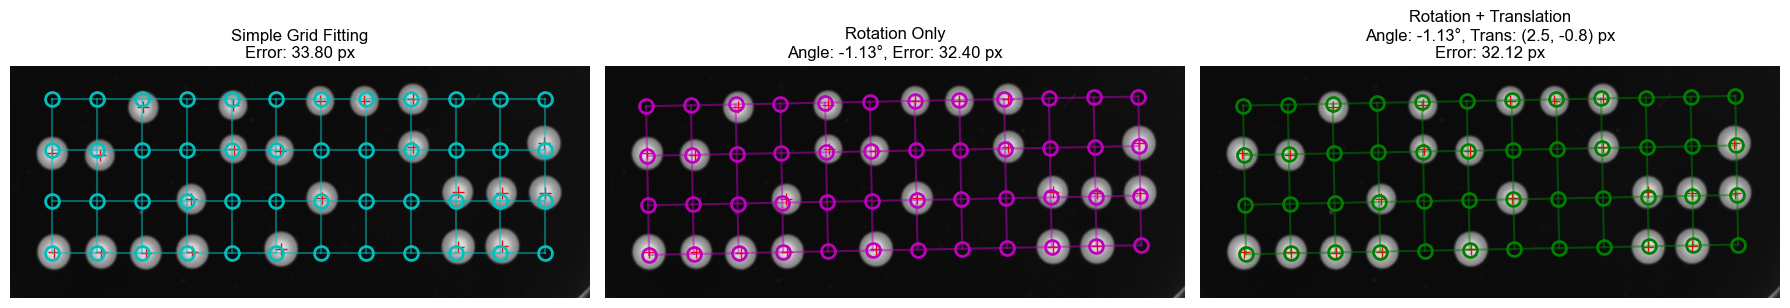


✅ The two-step method first applies rotation correction, then optimizes
   translation only if it improves the result. This avoids local optima.


In [69]:
# ============================================================
# 10.2 Grid Fitting with Rotation and Translation Optimization
# ============================================================

from scipy.optimize import minimize

def detect_rotation_angle_robust(centroids, n_rows=4, n_cols=12):
    """
    Detect rotation angle using robust row-based estimation.
    
    Algorithm:
    1. Sort centroids by y-coordinate to identify rows
    2. For each row, fit a line and calculate slope
    3. Use median slope as the rotation angle (robust to outliers)
    """
    pts = np.array(centroids)
    n_pts = len(pts)
    
    if n_pts < n_cols:
        return 0.0, []
    
    # Sort by y-coordinate
    sorted_indices = np.argsort(pts[:, 1])
    pts_sorted = pts[sorted_indices]
    
    # Divide into rows
    pts_per_row = n_pts // n_rows
    row_angles = []
    
    for i in range(n_rows):
        start_idx = i * pts_per_row
        end_idx = start_idx + pts_per_row if i < n_rows - 1 else n_pts
        row_pts = pts_sorted[start_idx:end_idx]
        
        if len(row_pts) >= 2:
            row_pts = row_pts[np.argsort(row_pts[:, 0])]
            
            if len(row_pts) >= 3:
                slopes = []
                for j in range(len(row_pts) - 1):
                    dx = row_pts[j+1, 0] - row_pts[j, 0]
                    dy = row_pts[j+1, 1] - row_pts[j, 1]
                    if abs(dx) > 1:
                        slopes.append(dy / dx)
                if slopes:
                    angle = np.degrees(np.arctan(np.median(slopes)))
                    row_angles.append(angle)
            else:
                dx = row_pts[-1, 0] - row_pts[0, 0]
                dy = row_pts[-1, 1] - row_pts[0, 1]
                if abs(dx) > 1:
                    angle = np.degrees(np.arctan(dy / dx))
                    row_angles.append(angle)
    
    if not row_angles:
        return 0.0, []
    
    angle_deg = np.median(row_angles)
    angle_deg = np.clip(angle_deg, -15, 15)
    
    return angle_deg, row_angles


def rotate_points(points, angle_deg, center):
    """Rotate points around a center by given angle."""
    angle_rad = np.radians(angle_deg)
    cos_a, sin_a = np.cos(angle_rad), np.sin(angle_rad)
    
    pts = np.array(points)
    pts_centered = pts - center
    
    rotated = np.zeros_like(pts_centered)
    rotated[:, 0] = pts_centered[:, 0] * cos_a - pts_centered[:, 1] * sin_a
    rotated[:, 1] = pts_centered[:, 0] * sin_a + pts_centered[:, 1] * cos_a
    
    return rotated + center


def calculate_grid_error(grid, centroids):
    """Calculate average distance from grid points to nearest centroids"""
    pts = np.array(centroids)
    grid_flat = grid.reshape(-1, 2)
    
    total_error = 0
    for gp in grid_flat:
        dists = np.linalg.norm(pts - gp, axis=1)
        total_error += np.min(dists)
    
    return total_error / len(grid_flat)


def fit_grid_with_rotation(centroids, n_rows=4, n_cols=12):
    """
    Fit grid using rotation correction only (no translation).
    """
    pts = np.array(centroids)
    center = pts.mean(axis=0)
    
    # Detect rotation angle
    angle_deg, row_angles = detect_rotation_angle_robust(centroids, n_rows, n_cols)
    
    # Rotate centroids to align with axes
    pts_aligned = rotate_points(pts, -angle_deg, center)
    
    # Fit grid on aligned points
    x_min, x_max = pts_aligned[:, 0].min(), pts_aligned[:, 0].max()
    y_min, y_max = pts_aligned[:, 1].min(), pts_aligned[:, 1].max()
    
    x_spacing = (x_max - x_min) / (n_cols - 1) if n_cols > 1 else 0
    y_spacing = (y_max - y_min) / (n_rows - 1) if n_rows > 1 else 0
    
    # Create aligned grid
    grid_aligned = np.zeros((n_rows, n_cols, 2))
    for row in range(n_rows):
        for col in range(n_cols):
            grid_aligned[row, col, 0] = x_min + col * x_spacing
            grid_aligned[row, col, 1] = y_min + row * y_spacing
    
    # Rotate grid back
    grid_flat = grid_aligned.reshape(-1, 2)
    grid_rotated = rotate_points(grid_flat, angle_deg, center)
    grid = grid_rotated.reshape(n_rows, n_cols, 2)
    
    return grid, {
        'x_spacing': x_spacing, 
        'y_spacing': y_spacing,
        'rotation_angle': angle_deg,
        'row_angles': row_angles,
        'center': center
    }


def fit_grid_rotation_then_translation(centroids, n_rows=4, n_cols=12, max_translation=30.0):
    """
    Two-step optimization: First rotation, then translation.
    
    Strategy:
    1. First fit grid with rotation correction (proven to work well)
    2. Then optimize translation using grid search + local optimization
    
    This avoids the joint optimization getting stuck in local optima.
    """
    pts = np.array(centroids)
    
    # Step 1: Get rotation-corrected grid (already works well)
    grid_rotated, params_rot = fit_grid_with_rotation(centroids, n_rows, n_cols)
    error_after_rotation = calculate_grid_error(grid_rotated, centroids)
    
    print(f"   Step 1 - Rotation correction:")
    print(f"      Rotation angle: {params_rot['rotation_angle']:.2f}°")
    print(f"      Error after rotation: {error_after_rotation:.2f} px")
    
    # Step 2: Optimize translation with grid search initialization
    print(f"   Step 2 - Translation optimization:")
    
    # Grid search for best translation starting point
    best_tx, best_ty = 0.0, 0.0
    best_error = error_after_rotation
    
    # Search in a grid pattern: -20 to +20 pixels in steps of 5
    search_range = np.arange(-20, 21, 5)
    
    for tx in search_range:
        for ty in search_range:
            grid_shifted = grid_rotated + np.array([tx, ty])
            err = calculate_grid_error(grid_shifted, centroids)
            if err < best_error:
                best_error = err
                best_tx, best_ty = tx, ty
    
    print(f"      Grid search best: tx={best_tx:.0f}, ty={best_ty:.0f}, error={best_error:.2f}")
    
    # Fine-tune with local optimization around the best grid search result
    def objective(params):
        tx, ty = params
        grid_shifted = grid_rotated + np.array([tx, ty])
        return calculate_grid_error(grid_shifted, centroids)
    
    # Start from grid search result
    result = minimize(objective, [best_tx, best_ty], method='L-BFGS-B',
                      bounds=[(-max_translation, max_translation), 
                              (-max_translation, max_translation)],
                      options={'ftol': 1e-8})
    
    tx_opt, ty_opt = result.x
    grid_final = grid_rotated + np.array([tx_opt, ty_opt])
    error_final = calculate_grid_error(grid_final, centroids)
    
    print(f"      Fine-tuned: tx={tx_opt:.1f}, ty={ty_opt:.1f}, error={error_final:.2f}")
    
    # Only use translation if it actually improves the result
    if error_final >= error_after_rotation:
        print(f"      Translation did not improve, using rotation-only result")
        return grid_rotated, {
            **params_rot,
            'translation': (0.0, 0.0),
            'translation_applied': False,
            'error_after_rotation': error_after_rotation,
            'error_final': error_after_rotation
        }
    
    improvement = (error_after_rotation - error_final) / error_after_rotation * 100
    print(f"      Translation improvement: {improvement:.1f}%")
    
    return grid_final, {
        **params_rot,
        'translation': (tx_opt, ty_opt),
        'translation_applied': True,
        'error_after_rotation': error_after_rotation,
        'error_final': error_final
    }


# ============================================================
# Demonstration: Compare all three methods
# ============================================================

print("=" * 60)
print("Grid Fitting Comparison: Simple vs Rotation vs Rotation+Translation")
print("=" * 60)

# Method 1: Simple grid (already computed in previous cell)
print("\n📏 Method 1: Simple Grid Fitting")
error_simple = calculate_grid_error(grid_centers, centroids_tetrad)
print(f"   Error: {error_simple:.2f} px")

# Method 2: Rotation only
print("\n📐 Method 2: Rotation Correction Only")
grid_rotated, params_rot = fit_grid_with_rotation(centroids_tetrad, n_rows=4, n_cols=12)
error_rotated = calculate_grid_error(grid_rotated, centroids_tetrad)
print(f"   Rotation angle: {params_rot['rotation_angle']:.2f}°")
print(f"   Error: {error_rotated:.2f} px")

# Method 3: Rotation + Translation (two-step)
print("\n🎯 Method 3: Rotation + Translation (Two-Step)")
grid_optimized, params_opt = fit_grid_rotation_then_translation(centroids_tetrad, n_rows=4, n_cols=12)
error_optimized = calculate_grid_error(grid_optimized, centroids_tetrad)

print(f"\n📊 Grid Alignment Error Summary:")
print(f"   Simple grid:              {error_simple:.2f} px")
print(f"   Rotation only:            {error_rotated:.2f} px")
print(f"   Rotation + Translation:   {error_optimized:.2f} px")

# Calculate improvements relative to simple grid
if error_simple > 0:
    imp_rot = (error_simple - error_rotated) / error_simple * 100
    imp_opt = (error_simple - error_optimized) / error_simple * 100
    print(f"\n   Improvement (rotation only):     {imp_rot:.1f}%")
    print(f"   Improvement (rotation+trans):    {imp_opt:.1f}%")


# Visualization: Compare all three methods
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Method 1: Simple grid
axes[0].imshow(tetrad_plate)
for (x, y) in centroids_tetrad:
    axes[0].plot(x, y, 'r+', markersize=8)
for row in range(4):
    for col in range(12):
        gx, gy = grid_centers[row, col]
        axes[0].plot(gx, gy, 'co', markersize=10, fillstyle='none', markeredgewidth=2)
for row in range(4):
    xs = [grid_centers[row, col, 0] for col in range(12)]
    ys = [grid_centers[row, col, 1] for col in range(12)]
    axes[0].plot(xs, ys, 'c-', alpha=0.5)
for col in range(12):
    xs = [grid_centers[row, col, 0] for row in range(4)]
    ys = [grid_centers[row, col, 1] for row in range(4)]
    axes[0].plot(xs, ys, 'c-', alpha=0.5)
axes[0].set_title(f'Simple Grid Fitting\nError: {error_simple:.2f} px')
axes[0].axis('off')

# Method 2: Rotation only
axes[1].imshow(tetrad_plate)
for (x, y) in centroids_tetrad:
    axes[1].plot(x, y, 'r+', markersize=8)
for row in range(4):
    for col in range(12):
        gx, gy = grid_rotated[row, col]
        axes[1].plot(gx, gy, 'mo', markersize=10, fillstyle='none', markeredgewidth=2)
for row in range(4):
    xs = [grid_rotated[row, col, 0] for col in range(12)]
    ys = [grid_rotated[row, col, 1] for col in range(12)]
    axes[1].plot(xs, ys, 'm-', alpha=0.5)
for col in range(12):
    xs = [grid_rotated[row, col, 0] for row in range(4)]
    ys = [grid_rotated[row, col, 1] for row in range(4)]
    axes[1].plot(xs, ys, 'm-', alpha=0.5)
axes[1].set_title(f'Rotation Only\nAngle: {params_rot["rotation_angle"]:.2f}°, Error: {error_rotated:.2f} px')
axes[1].axis('off')

# Method 3: Rotation + Translation
axes[2].imshow(tetrad_plate)
for (x, y) in centroids_tetrad:
    axes[2].plot(x, y, 'r+', markersize=8)
for row in range(4):
    for col in range(12):
        gx, gy = grid_optimized[row, col]
        axes[2].plot(gx, gy, 'go', markersize=10, fillstyle='none', markeredgewidth=2)
for row in range(4):
    xs = [grid_optimized[row, col, 0] for col in range(12)]
    ys = [grid_optimized[row, col, 1] for col in range(12)]
    axes[2].plot(xs, ys, 'g-', alpha=0.5)
for col in range(12):
    xs = [grid_optimized[row, col, 0] for row in range(4)]
    ys = [grid_optimized[row, col, 1] for row in range(4)]
    axes[2].plot(xs, ys, 'g-', alpha=0.5)

tx, ty = params_opt['translation']
trans_str = f"Trans: ({tx:.1f}, {ty:.1f}) px" if params_opt.get('translation_applied', False) else "No trans needed"
axes[2].set_title(f'Rotation + Translation\nAngle: {params_opt["rotation_angle"]:.2f}°, {trans_str}\nError: {error_optimized:.2f} px')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("\n✅ The two-step method first applies rotation correction, then optimizes")
print("   translation only if it improves the result. This avoids local optima.")

---
## 第十一章：改进的信号检测 — SNR 方法

### 11.1 简单阈值方法的问题

对于 **Essential Gene** 的情况：
- Tetrad 平板：只有 2 个 WT 存活，2 个 DEL 致死
- HYG 平板：WT 无抗性不长，DEL 致死也不长
- 但转印痕迹可能被误判为信号！

### 11.2 SNR (信噪比) 方法

**信噪比** = $\frac{\text{信号} - \text{背景}}{\text{背景标准差}}$

| SNR 值 | 意义 |
|--------|------|
| < 1 | 与背景无差异 |
| 1-2 | 可能是噪声 |
| **> 2** | 真实信号 |
| > 3 | 强信号 |

### 11.3 背景估计方法

在网格点**之间**的区域采样，这些位置应该没有菌落。

📊 Background: mean=53.7, std=3.8
   SNR range: -0.62 ~ 3.65

Results with different SNR thresholds:
   SNR > 1.5: DEL=23, WT=25
   SNR > 2.0: DEL=20, WT=28
   SNR > 2.5: DEL=14, WT=34
   SNR > 3.0: DEL=5, WT=43


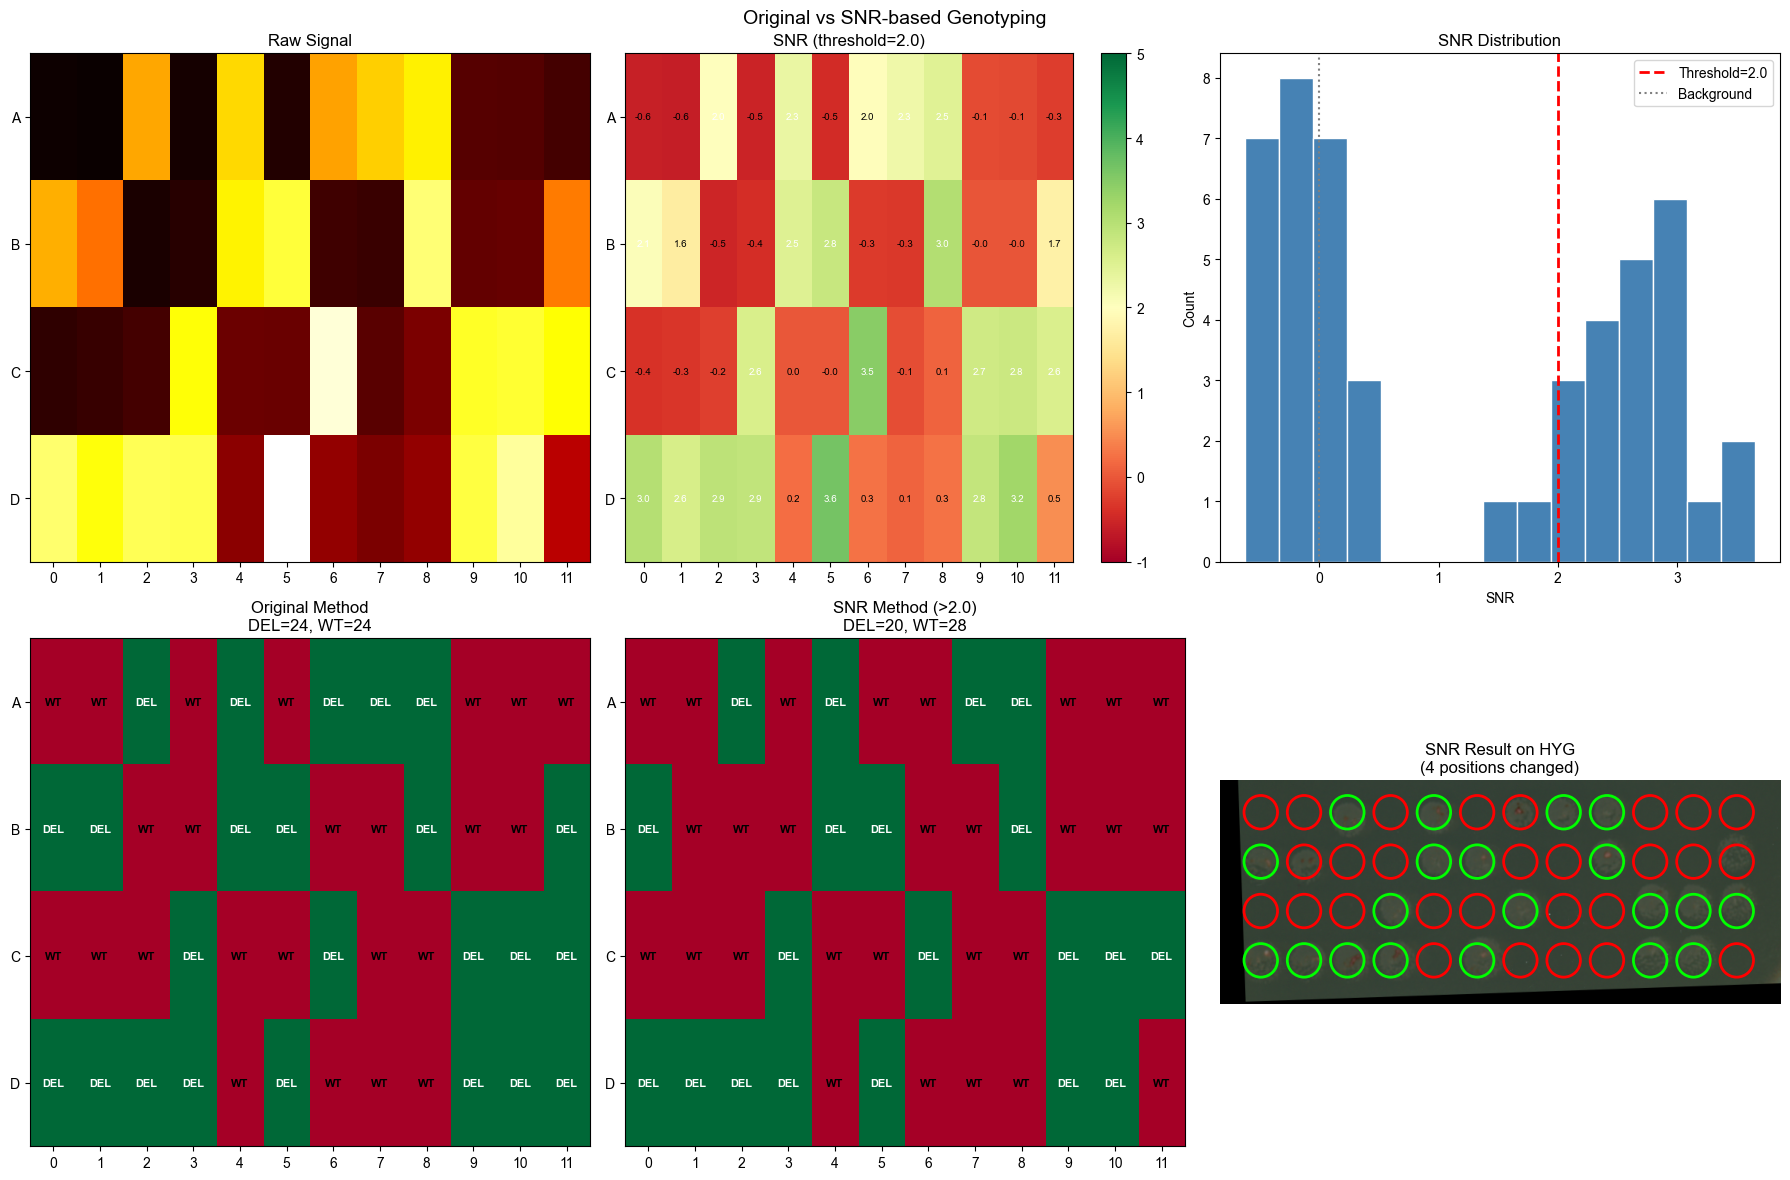


📝 Method comparison:
   Original method (Otsu): DEL=24, WT=24
   SNR method (>2.0): DEL=20, WT=28
   Changed positions: 4



In [70]:
# ============================================================
# 11. SNR Method — Improved Signal Detection
# ============================================================

def estimate_background(image, grid, grid_params):
    """Estimate background intensity: sample between grid points"""
    h, w = image.shape[:2]
    gray = image[:, :, 0].astype(float) if image.ndim == 3 else image.astype(float)
    
    n_rows, n_cols = grid.shape[:2]
    x_spacing = grid_params['x_spacing']
    y_spacing = grid_params['y_spacing']
    
    bg_samples = []
    
    # Sample between columns
    for row in range(n_rows):
        for col in range(n_cols - 1):
            x1, y1 = grid[row, col]
            x2, y2 = grid[row, col + 1]
            mid_x, mid_y = int((x1 + x2) / 2), int((y1 + y2) / 2)
            
            if 5 < mid_x < w - 5 and 5 < mid_y < h - 5:
                bg_samples.append(np.mean(gray[mid_y-3:mid_y+4, mid_x-3:mid_x+4]))
    
    # Sample between rows
    for row in range(n_rows - 1):
        for col in range(n_cols):
            x1, y1 = grid[row, col]
            x2, y2 = grid[row + 1, col]
            mid_x, mid_y = int((x1 + x2) / 2), int((y1 + y2) / 2)
            
            if 5 < mid_x < w - 5 and 5 < mid_y < h - 5:
                bg_samples.append(np.mean(gray[mid_y-3:mid_y+4, mid_x-3:mid_x+4]))
    
    return np.median(bg_samples), np.std(bg_samples)


def measure_signal_with_snr(image, grid, radius, bg_mean, bg_std):
    """Calculate signal and SNR"""
    n_rows, n_cols = grid.shape[:2]
    h, w = image.shape[:2]
    gray = image[:, :, 0].astype(float) if image.ndim == 3 else image.astype(float)
    
    raw_signals = np.zeros((n_rows, n_cols))
    snr = np.zeros((n_rows, n_cols))
    
    for row in range(n_rows):
        for col in range(n_cols):
            cx, cy = int(grid[row, col, 0]), int(grid[row, col, 1])
            
            x1, x2 = max(0, cx - radius), min(w, cx + radius + 1)
            y1, y2 = max(0, cy - radius), min(h, cy + radius + 1)
            
            if x2 > x1 and y2 > y1:
                signal = np.mean(gray[y1:y2, x1:x2])
                raw_signals[row, col] = signal
                snr[row, col] = (signal - bg_mean) / bg_std if bg_std > 0 else 0
    
    return raw_signals, snr


def genotype_by_snr(snr, snr_threshold=2.0):
    """Genotype based on SNR"""
    genotypes = np.where(snr > snr_threshold, 'DEL', 'WT')
    return genotypes

# Apply SNR method
bg_mean, bg_std = estimate_background(hyg_aligned, grid_centers, grid_params)
print(f"📊 Background: mean={bg_mean:.1f}, std={bg_std:.1f}")

raw_signals, snr = measure_signal_with_snr(hyg_aligned, grid_centers, measure_radius, bg_mean, bg_std)
print(f"   SNR range: {snr.min():.2f} ~ {snr.max():.2f}")

# Test with different thresholds
print("\nResults with different SNR thresholds:")
for snr_th in [1.5, 2.0, 2.5, 3.0]:
    gt = genotype_by_snr(snr, snr_th)
    print(f"   SNR > {snr_th}: DEL={np.sum(gt=='DEL')}, WT={np.sum(gt=='WT')}")

# Use recommended threshold
genotypes_snr = genotype_by_snr(snr, snr_threshold=2.0)
del_snr = np.sum(genotypes_snr == 'DEL')
wt_snr = np.sum(genotypes_snr == 'WT')

# Visualization comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Row 1: Signal analysis
axes[0, 0].imshow(raw_signals, cmap='hot', aspect='auto')
axes[0, 0].set_title('Raw Signal')
axes[0, 0].set_xticks(range(12))
axes[0, 0].set_yticks(range(4))
axes[0, 0].set_yticklabels(['A', 'B', 'C', 'D'])

im = axes[0, 1].imshow(snr, cmap='RdYlGn', aspect='auto', vmin=-1, vmax=5)
axes[0, 1].set_title('SNR (threshold=2.0)')
axes[0, 1].set_xticks(range(12))
axes[0, 1].set_yticks(range(4))
axes[0, 1].set_yticklabels(['A', 'B', 'C', 'D'])
for row in range(4):
    for col in range(12):
        color = 'white' if snr[row, col] >= 2.0 else 'black'
        axes[0, 1].text(col, row, f'{snr[row, col]:.1f}', ha='center', va='center', 
                       fontsize=7, color=color)
plt.colorbar(im, ax=axes[0, 1])

axes[0, 2].hist(snr.flatten(), bins=15, color='steelblue', edgecolor='white')
axes[0, 2].axvline(2.0, color='red', linestyle='--', linewidth=2, label='Threshold=2.0')
axes[0, 2].axvline(0, color='gray', linestyle=':', label='Background')
axes[0, 2].set_xlabel('SNR')
axes[0, 2].set_ylabel('Count')
axes[0, 2].set_title('SNR Distribution')
axes[0, 2].legend()

# Row 2: Method comparison
gt_orig = np.where(genotypes == 'DEL', 1, 0)
axes[1, 0].imshow(gt_orig, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
for row in range(4):
    for col in range(12):
        color = 'white' if genotypes[row, col] == 'DEL' else 'black'
        axes[1, 0].text(col, row, genotypes[row, col], ha='center', va='center', 
                       fontsize=8, color=color, fontweight='bold')
axes[1, 0].set_title(f'Original Method\nDEL={del_count}, WT={wt_count}')
axes[1, 0].set_xticks(range(12))
axes[1, 0].set_yticks(range(4))
axes[1, 0].set_yticklabels(['A', 'B', 'C', 'D'])

gt_snr = np.where(genotypes_snr == 'DEL', 1, 0)
axes[1, 1].imshow(gt_snr, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
for row in range(4):
    for col in range(12):
        color = 'white' if genotypes_snr[row, col] == 'DEL' else 'black'
        axes[1, 1].text(col, row, genotypes_snr[row, col], ha='center', va='center', 
                       fontsize=8, color=color, fontweight='bold')
axes[1, 1].set_title(f'SNR Method (>2.0)\nDEL={del_snr}, WT={wt_snr}')
axes[1, 1].set_xticks(range(12))
axes[1, 1].set_yticks(range(4))
axes[1, 1].set_yticklabels(['A', 'B', 'C', 'D'])

# Change comparison
changed = genotypes != genotypes_snr
change_count = np.sum(changed)
axes[1, 2].imshow(hyg_aligned)
for row in range(4):
    for col in range(12):
        gx, gy = grid_centers[row, col]
        color = 'lime' if genotypes_snr[row, col] == 'DEL' else 'red'
        circ = Circle((gx, gy), radius=measure_radius, color=color, fill=False, linewidth=2)
        axes[1, 2].add_patch(circ)
axes[1, 2].set_title(f'SNR Result on HYG\n({change_count} positions changed)')
axes[1, 2].axis('off')

plt.suptitle('Original vs SNR-based Genotyping', fontsize=14)
plt.tight_layout()
plt.show()

print(f"""
📝 Method comparison:
   Original method (Otsu): DEL={del_count}, WT={wt_count}
   SNR method (>2.0): DEL={del_snr}, WT={wt_snr}
   Changed positions: {change_count}
""")

---
## 📋 总结

### 完整流程回顾

```
┌─────────────────────────────────────────────────────────────┐
│  1. 读取图像          skimage.io.imread                     │
│        ↓                                                     │
│  2. 灰度转换          np.mean / 取单通道                      │
│        ↓                                                     │
│  3. 高斯模糊          filters.gaussian (σ=1.0)               │
│        ↓                                                     │
│  4. Otsu 阈值         filters.threshold_otsu                 │
│        ↓                                                     │
│  5. 形态学开运算      morphology.binary_opening (disk=3)     │
│        ↓                                                     │
│  6. 分水岭分割        segmentation.watershed (如需要)        │
│        ↓                                                     │
│  7. 区域属性提取      measure.label + regionprops            │
│        ↓                                                     │
│  8. 图像对齐          cv2.estimateAffinePartial2D + warpAffine│
│        ↓                                                     │
│  9. 网格拟合          PCA + 边界框                           │
│        ↓                                                     │
│  10. 信号测量         SNR 方法                               │
│        ↓                                                     │
│  11. 基因型判断       SNR > 2.0 → DEL                        │
└─────────────────────────────────────────────────────────────┘
```

### 关键库速查表

| 库 | 主要函数 | 用途 |
|---|---|---|
| `skimage.filters` | `gaussian`, `threshold_otsu` | 模糊、阈值 |
| `skimage.morphology` | `binary_opening`, `disk` | 形态学操作 |
| `skimage.measure` | `label`, `regionprops` | 区域分析 |
| `skimage.segmentation` | `watershed` | 分水岭分割 |
| `scipy.ndimage` | `distance_transform_edt` | 距离变换 |
| `scipy.spatial` | `distance.cdist` | 距离矩阵 |
| `scipy.optimize` | `linear_sum_assignment` | 匈牙利匹配 |
| `cv2` | `estimateAffinePartial2D`, `warpAffine` | 图像对齐 |

### 推荐参数

| 参数 | Tetrad 平板 | HYG 平板 |
|------|------------|---------|
| 灰度方法 | `np.mean()` | 红色通道 |
| 高斯 σ | 1.0 - 2.0 | 0.5 - 1.0 |
| 开运算 disk | 3 | 3 |
| SNR 阈值 | - | 2.0 |

In [ ]:
print("🎉 Tutorial complete!")
print("""
Now you should have mastered:
  ✅ Basic image preprocessing workflow
  ✅ Principles and applications of morphological operations
  ✅ Watershed algorithm for separating fused colonies
  ✅ Image alignment methods
  ✅ Grid-based and SNR genotyping

Below is a complete analysis function that can be used directly to analyze new images.
""")

---
## 🛠️ 实用工具：一键分析函数

下面提供一个完整的分析函数，集成了本教程中所有的步骤：
- 自动检测菌落
- 图像对齐
- 网格拟合
- SNR 信号检测
- 基因型判断

### 使用方法

```python
results = analyze_tetrad_pair(
    tetrad_path='path/to/tetrad.png',
    hyg_path='path/to/hyg.png'
)
```


Usage Example
🔬 Tetrad Analysis
✅ Images loaded: Tetrad (294, 735, 3), HYG (294, 735, 3)
   Detected 23 colonies on Tetrad
   ✅ HYG aligned

📊 Result: DEL=21, WT=27


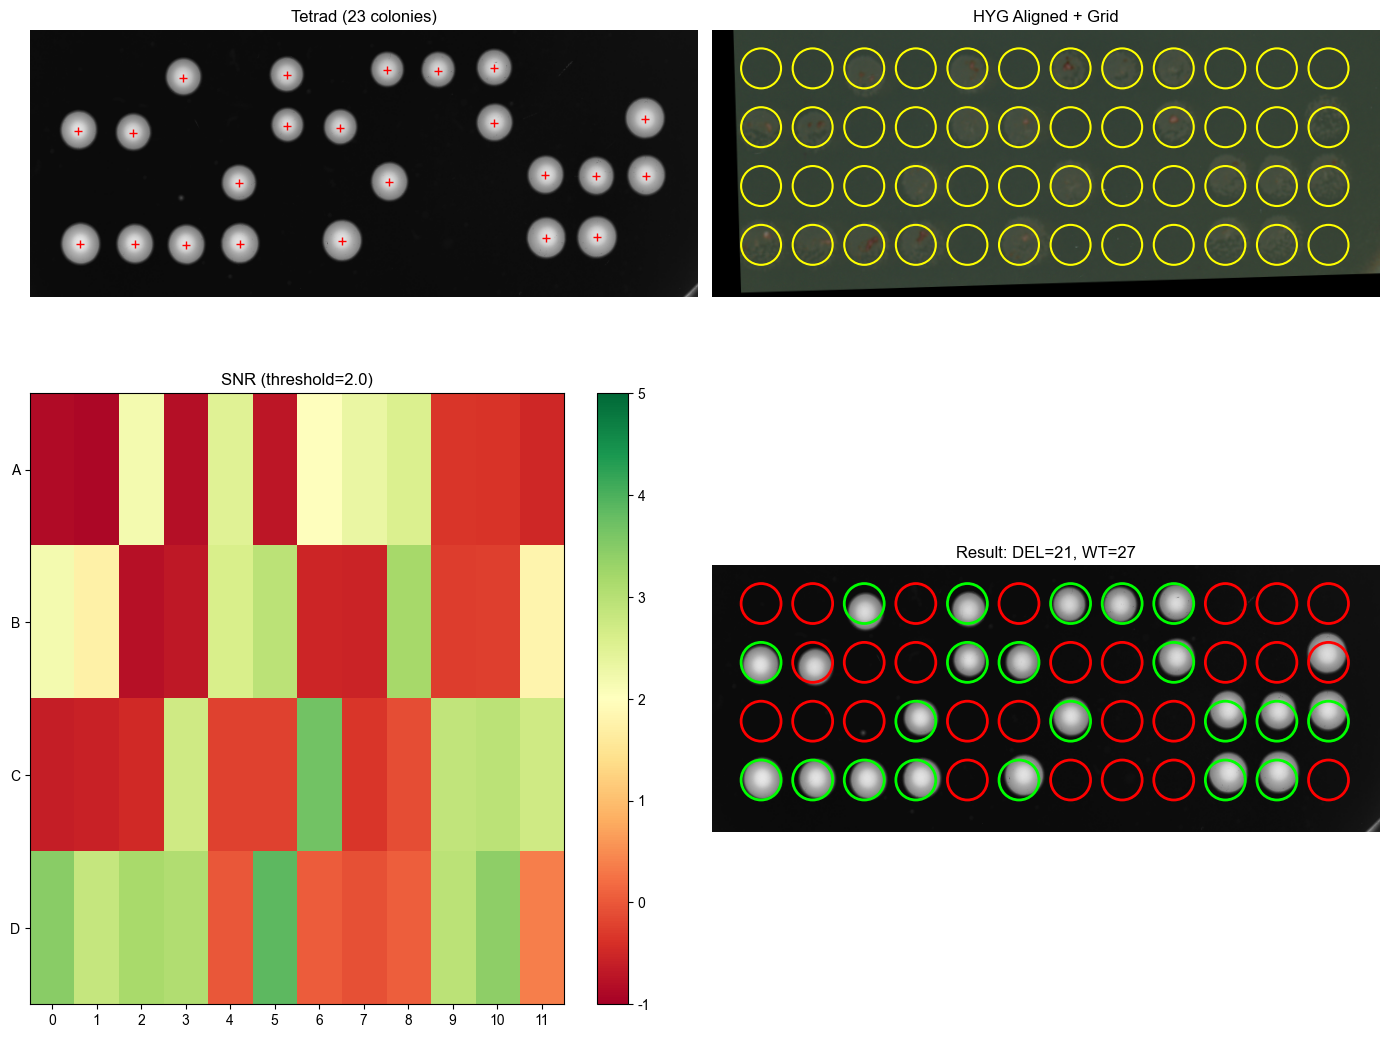

In [71]:
# ============================================================
# Complete Analysis Function
# ============================================================

def analyze_tetrad_pair(tetrad_path, hyg_path, snr_threshold=2.0, show_plots=True):
    """
    One-click analysis of Tetrad and HYG image pair.
    
    Args:
        tetrad_path: Tetrad plate image path
        hyg_path: HYG plate image path
        snr_threshold: SNR threshold (default 2.0)
        show_plots: Whether to show result plots
        
    Returns:
        results: Dictionary containing genotype results
    """
    print("=" * 60)
    print("🔬 Tetrad Analysis")
    print("=" * 60)
    
    # 1. Read images
    tetrad_img = io.imread(tetrad_path)
    hyg_img = io.imread(hyg_path)
    print(f"✅ Images loaded: Tetrad {tetrad_img.shape}, HYG {hyg_img.shape}")
    
    # 2. Detect Tetrad colonies
    gray_tetrad = np.mean(tetrad_img, axis=2)
    blurred = gaussian(gray_tetrad, sigma=2)
    thresh = threshold_otsu(blurred)
    binary = blurred > thresh
    cleaned = morphology.binary_opening(binary, morphology.disk(3))
    labeled = measure.label(cleaned)
    props = measure.regionprops(labeled)
    
    centroids = [(p.centroid[1], p.centroid[0]) for p in props if p.area > 100]
    print(f"   Detected {len(centroids)} colonies on Tetrad")
    
    # 3. Resize and align HYG
    h_ref, w_ref = tetrad_img.shape[:2]
    hyg_resized = cv2.resize(hyg_img, (w_ref, h_ref))
    
    # Detect HYG colonies
    gray_hyg = hyg_resized[:, :, 0].astype(float)
    blurred_hyg = gaussian(gray_hyg, sigma=1)
    thresh_hyg = threshold_otsu(blurred_hyg)
    binary_hyg = blurred_hyg > thresh_hyg
    cleaned_hyg = morphology.binary_opening(binary_hyg, morphology.disk(3))
    labeled_hyg = measure.label(cleaned_hyg)
    props_hyg = measure.regionprops(labeled_hyg)
    centroids_hyg = [(p.centroid[1], p.centroid[0]) for p in props_hyg if p.area > 50]
    
    # Alignment
    hyg_aligned = hyg_resized
    if len(centroids) >= 4 and len(centroids_hyg) >= 4:
        pts_t = np.array(centroids).astype(np.float32)
        pts_h = np.array(centroids_hyg).astype(np.float32)
        
        dist_mat = cdist(pts_t, pts_h)
        row_ind, col_ind = linear_sum_assignment(dist_mat)
        
        valid = dist_mat[row_ind, col_ind] < 50
        if np.sum(valid) >= 4:
            matched_t = pts_t[row_ind[valid]]
            matched_h = pts_h[col_ind[valid]]
            
            M, _ = cv2.estimateAffinePartial2D(
                matched_h.reshape(-1, 1, 2),
                matched_t.reshape(-1, 1, 2),
                method=cv2.RANSAC
            )
            if M is not None:
                hyg_aligned = cv2.warpAffine(hyg_resized, M, (w_ref, h_ref))
                print("   ✅ HYG aligned")
    
    # 4. Fit grid
    pts = np.array(centroids)
    x_min, x_max = pts[:, 0].min(), pts[:, 0].max()
    y_min, y_max = pts[:, 1].min(), pts[:, 1].max()
    
    n_rows, n_cols = 4, 12
    x_sp = (x_max - x_min) / (n_cols - 1)
    y_sp = (y_max - y_min) / (n_rows - 1)
    
    grid = np.zeros((n_rows, n_cols, 2))
    for r in range(n_rows):
        for c in range(n_cols):
            grid[r, c, 0] = x_min + c * x_sp
            grid[r, c, 1] = y_min + r * y_sp
    
    # 5. Measure signal and SNR
    radius = int(y_sp * 0.35)
    gray_hyg_aligned = hyg_aligned[:, :, 0].astype(float)
    
    # Background estimation
    bg_samples = []
    for r in range(n_rows):
        for c in range(n_cols - 1):
            mx = int((grid[r, c, 0] + grid[r, c+1, 0]) / 2)
            my = int((grid[r, c, 1] + grid[r, c+1, 1]) / 2)
            if 5 < mx < w_ref - 5 and 5 < my < h_ref - 5:
                bg_samples.append(np.mean(gray_hyg_aligned[my-3:my+4, mx-3:mx+4]))
    
    bg_mean, bg_std = np.median(bg_samples), np.std(bg_samples)
    
    # Signal measurement
    signals = np.zeros((n_rows, n_cols))
    snr = np.zeros((n_rows, n_cols))
    
    for r in range(n_rows):
        for c in range(n_cols):
            cx, cy = int(grid[r, c, 0]), int(grid[r, c, 1])
            x1, x2 = max(0, cx - radius), min(w_ref, cx + radius + 1)
            y1, y2 = max(0, cy - radius), min(h_ref, cy + radius + 1)
            
            if x2 > x1 and y2 > y1:
                sig = np.mean(gray_hyg_aligned[y1:y2, x1:x2])
                signals[r, c] = sig
                snr[r, c] = (sig - bg_mean) / bg_std if bg_std > 0 else 0
    
    # 6. Genotyping
    genotypes = np.where(snr > snr_threshold, 'DEL', 'WT')
    del_count = np.sum(genotypes == 'DEL')
    wt_count = np.sum(genotypes == 'WT')
    
    print(f"\n📊 Result: DEL={del_count}, WT={wt_count}")
    
    # 7. Visualization
    if show_plots:
        fig, axes = plt.subplots(2, 2, figsize=(14, 12))
        
        axes[0, 0].imshow(tetrad_img)
        for x, y in centroids:
            axes[0, 0].plot(x, y, 'r+', markersize=6)
        axes[0, 0].set_title(f'Tetrad ({len(centroids)} colonies)')
        axes[0, 0].axis('off')
        
        axes[0, 1].imshow(hyg_aligned)
        for r in range(n_rows):
            for c in range(n_cols):
                gx, gy = grid[r, c]
                circ = Circle((gx, gy), radius=radius, color='yellow', fill=False, linewidth=1.5)
                axes[0, 1].add_patch(circ)
        axes[0, 1].set_title('HYG Aligned + Grid')
        axes[0, 1].axis('off')
        
        im = axes[1, 0].imshow(snr, cmap='RdYlGn', aspect='auto', vmin=-1, vmax=5)
        axes[1, 0].set_title(f'SNR (threshold={snr_threshold})')
        axes[1, 0].set_xticks(range(12))
        axes[1, 0].set_yticks(range(4))
        axes[1, 0].set_yticklabels(['A', 'B', 'C', 'D'])
        plt.colorbar(im, ax=axes[1, 0])
        
        axes[1, 1].imshow(tetrad_img)
        for r in range(n_rows):
            for c in range(n_cols):
                gx, gy = grid[r, c]
                color = 'lime' if genotypes[r, c] == 'DEL' else 'red'
                circ = Circle((gx, gy), radius=radius, color=color, fill=False, linewidth=2)
                axes[1, 1].add_patch(circ)
        axes[1, 1].set_title(f'Result: DEL={del_count}, WT={wt_count}')
        axes[1, 1].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    return {
        'genotypes': genotypes,
        'snr': snr,
        'signals': signals,
        'del_count': del_count,
        'wt_count': wt_count,
        'grid': grid
    }

# Test
print("\n" + "=" * 60)
print("Usage Example")
print("=" * 60)

results = analyze_tetrad_pair(TETRAD_PATH, HYG_PATH)

---
## 📚 扩展阅读与参考资源

### 官方文档
- [scikit-image Documentation](https://scikit-image.org/docs/stable/)
- [OpenCV Python Tutorial](https://docs.opencv.org/4.x/d6/d00/tutorial_py_root.html)
- [NumPy User Guide](https://numpy.org/doc/stable/user/index.html)

### 推荐学习路径

1. **基础图像处理** → scikit-image tutorials
2. **形态学操作深入** → Mathematical Morphology
3. **机器学习方法** → scikit-learn for colony classification

### 联系方式

如有问题或建议，请联系：[Your Email]

---

**🎉 恭喜完成本教程！**

---
## 🚀 改进版完整分析示例

下面演示如何使用新的改进分析函数。

### 关键改进

1. **所有功能已封装为函数** - 可在其他脚本中复用
2. **HYG 检测改进** - 基于 Tetrad 网格，无需独立检测菌落
3. **综合判断逻辑** - 结合 Tetrad 和 HYG 信息
4. **支持 Essential/Non-Essential 基因** - 自动应用不同判断规则

### 新的分析流程

```
Tetrad 图像 → 检测菌落 → 拟合网格 ┐
                                  ├→ 对齐 HYG → 在网格位置测量 SNR → 综合判断
HYG 图像 → (仅用于对齐) ────────────┘
```

### 使用方法

示例 1: Non-Essential Gene 分析
🔬 Tetrad-HYG 图像对分析
✅ 图像已加载:
   Tetrad: (294, 735, 3)
   HYG: (294, 735, 3)

📍 步骤 1: 检测 Tetrad 菌落
   检测到 23 个菌落

📐 步骤 2: 拟合网格 (方法: rotation)
   网格间距: X=56.7 px, Y=62.8 px
   旋转角度: -1.13°
   Tetrad 菌落分布: 23/48 位置有菌落

🔄 步骤 3: 对齐 HYG 图像
   HYG 检测到 26 个特征点用于对齐
   匹配点对: 23
   变换参数:
      缩放: 1.0033
      旋转: -2.15°
      平移: (22.5, -1.8) px

📊 步骤 4: 在 HYG 上测量信号 (使用 Tetrad 网格)
   测量半径: 21 px
   背景: mean=53.4, std=2.7
   SNR 范围: -0.73 ~ 5.53
   HYG 存在 (SNR>2.0): 23/48

🧬 步骤 5: 综合判断基因型 (类型: non-essential)
   结果统计:
      DEL: 23
      Unknown: 25


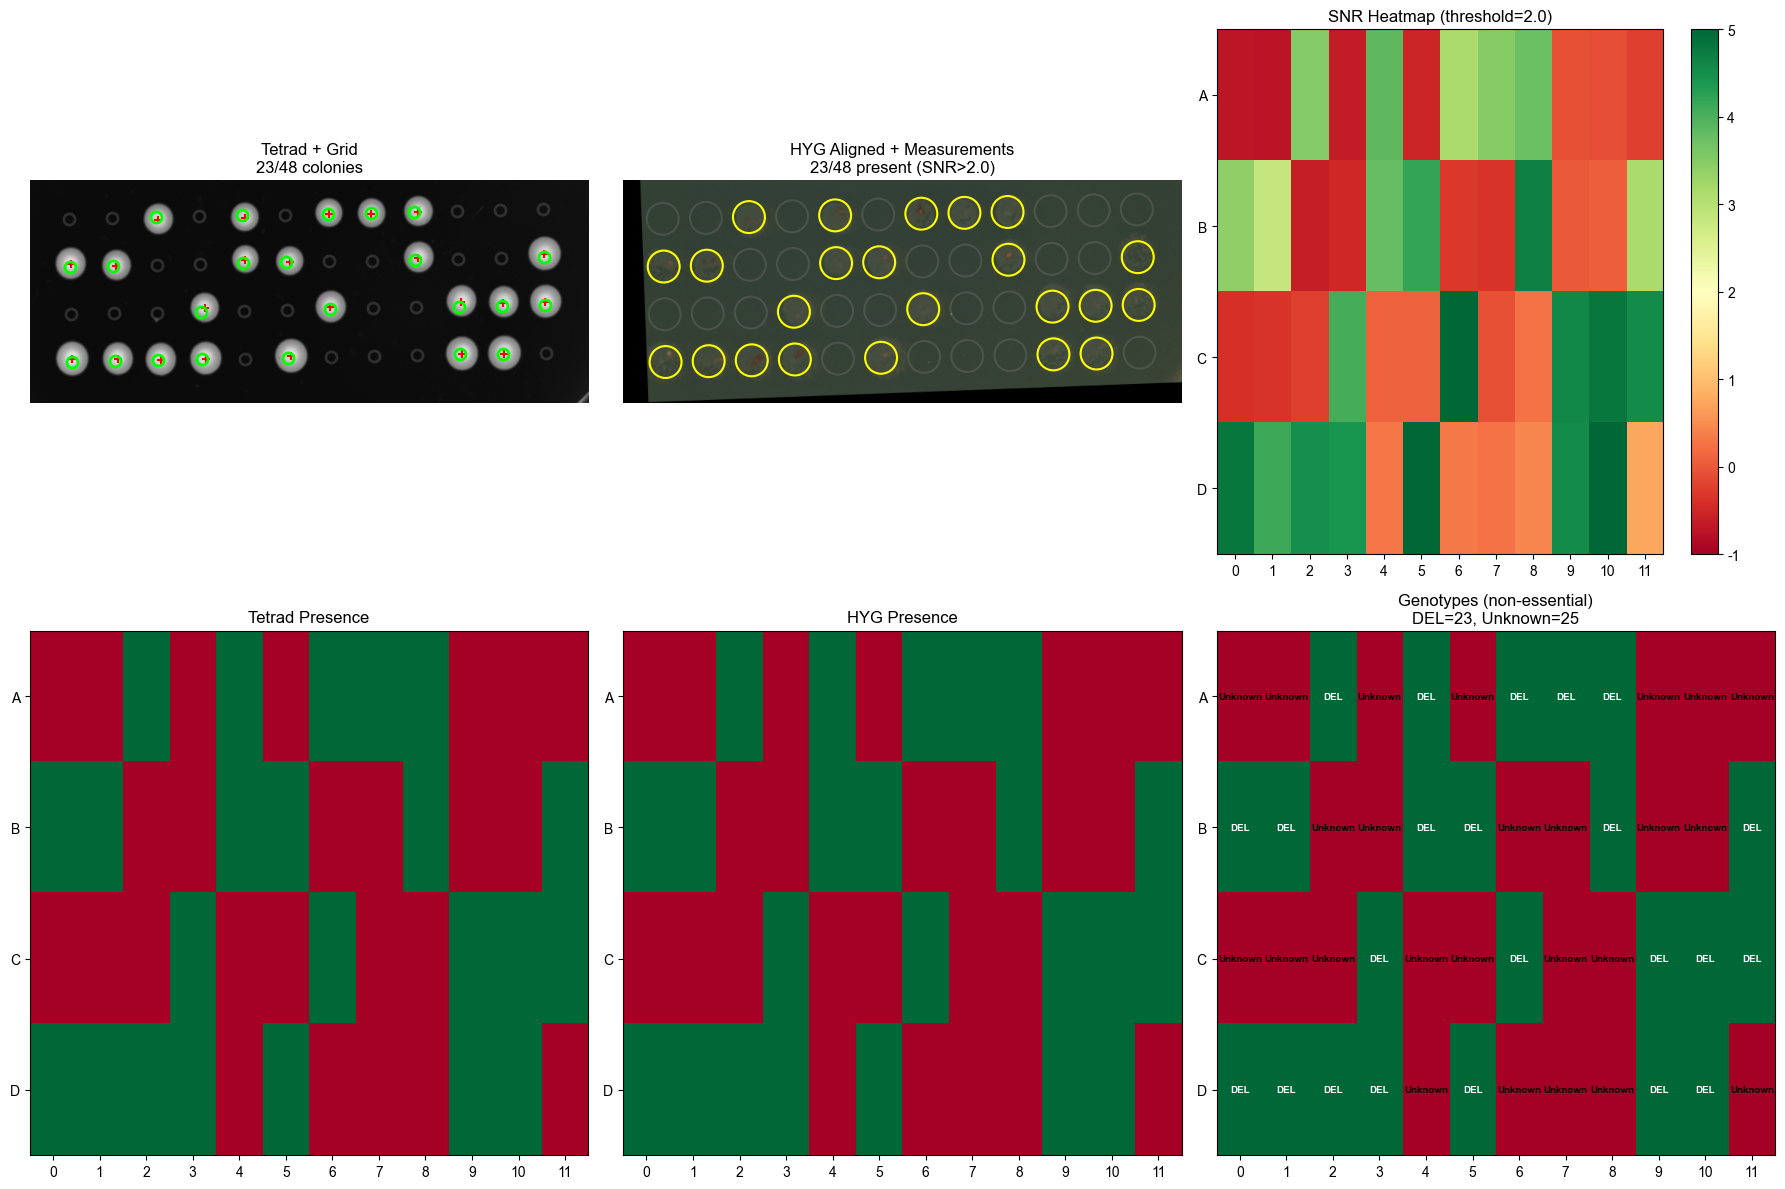


✅ 分析完成！

📊 详细统计:
   DEL 菌落: 23
   WT 菌落:  0
   未知:     25


In [72]:
# ============================================================
# 示例 1: Non-Essential Gene 分析 (使用改进的方法)
# ============================================================

print("示例 1: Non-Essential Gene 分析")
print("=" * 70)

# 使用一键分析函数
results_non_essential = analyze_tetrad_hyg_pair(
    tetrad_path=str(TETRAD_PATH),
    hyg_path=str(HYG_PATH),
    n_rows=4,
    n_cols=12,
    gene_type='non-essential',      # Non-Essential Gene
    grid_method='rotation',          # 使用旋转校正
    snr_threshold=2.0,              # SNR 阈值
    show_plots=True,
    verbose=True
)

print("\n📊 详细统计:")
print(f"   DEL 菌落: {results_non_essential['summary'].get('DEL', 0)}")
print(f"   WT 菌落:  {results_non_essential['summary'].get('WT', 0)}")
print(f"   未知:     {results_non_essential['summary'].get('Unknown', 0)}")

### Essential Gene 示例

对于 Essential Gene，判断逻辑不同：
- **Tetrad 有 + HYG 无** → WT (存活但无抗性)
- **Tetrad 无 + HYG 无** → DEL (致死)
- **Tetrad 无 + HYG 有** → 转印痕迹 (假阳性)


示例 2: Essential Gene 分析 (演示)
(注意: 使用相同图像仅为演示，实际应使用 Essential Gene 数据)
🔬 Tetrad-HYG 图像对分析
✅ 图像已加载:
   Tetrad: (294, 735, 3)
   HYG: (294, 735, 3)

📍 步骤 1: 检测 Tetrad 菌落
   检测到 23 个菌落

📐 步骤 2: 拟合网格 (方法: rotation)
   网格间距: X=56.7 px, Y=62.8 px
   旋转角度: -1.13°
   Tetrad 菌落分布: 23/48 位置有菌落

🔄 步骤 3: 对齐 HYG 图像
   HYG 检测到 26 个特征点用于对齐
   匹配点对: 23
   变换参数:
      缩放: 1.0033
      旋转: -2.15°
      平移: (22.5, -1.8) px

📊 步骤 4: 在 HYG 上测量信号 (使用 Tetrad 网格)
   测量半径: 21 px
   背景: mean=53.4, std=2.7
   SNR 范围: -0.73 ~ 5.53
   HYG 存在 (SNR>2.0): 23/48

🧬 步骤 5: 综合判断基因型 (类型: essential)
   结果统计:
      DEL: 25
      Unknown: 23


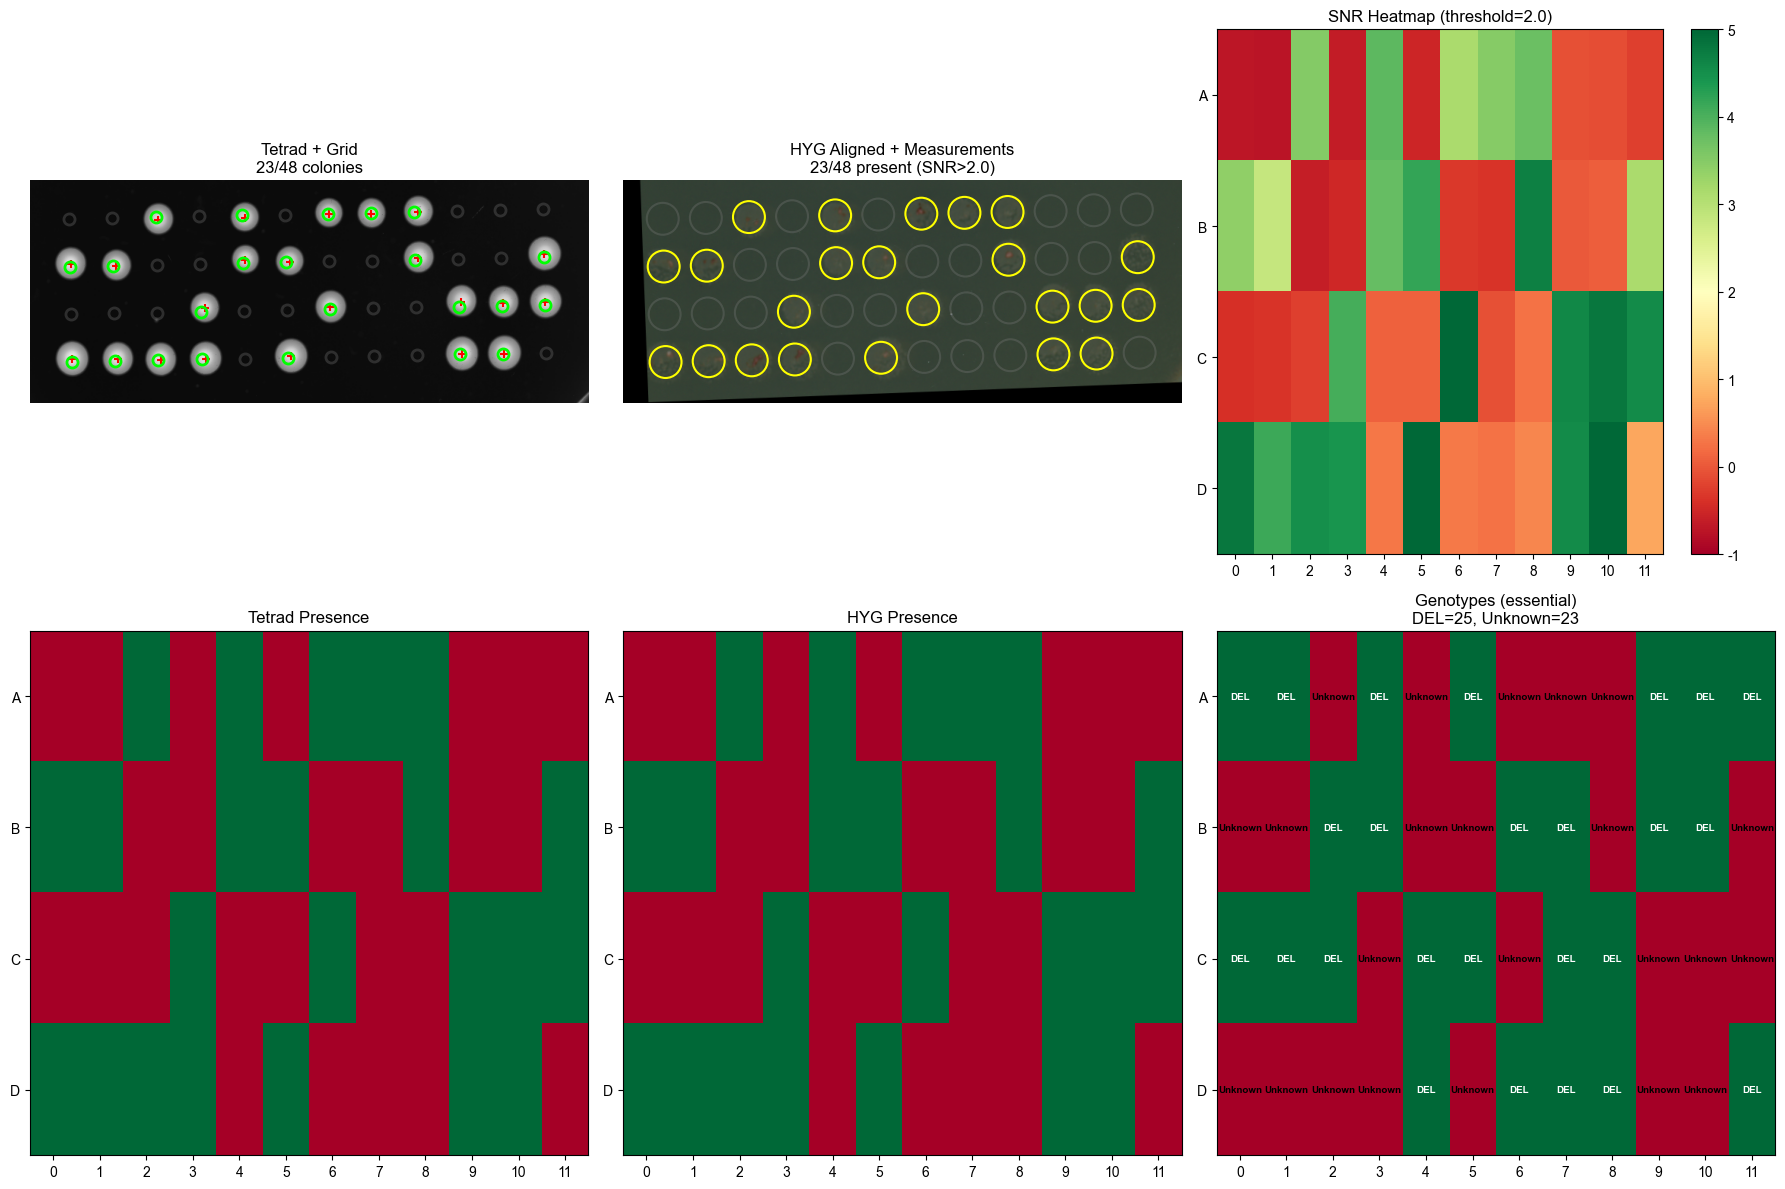


✅ 分析完成！


In [73]:
# ============================================================
# 示例 2: Essential Gene 分析 (如果有 Essential Gene 数据)
# ============================================================

# 注意：这里使用相同的图像只是为了演示，实际使用时应该用 Essential Gene 的图像
print("\n示例 2: Essential Gene 分析 (演示)")
print("=" * 70)
print("(注意: 使用相同图像仅为演示，实际应使用 Essential Gene 数据)")

results_essential = analyze_tetrad_hyg_pair(
    tetrad_path=str(TETRAD_PATH),
    hyg_path=str(HYG_PATH),
    n_rows=4,
    n_cols=12,
    gene_type='essential',          # Essential Gene
    grid_method='rotation',
    snr_threshold=2.0,
    show_plots=True,
    verbose=True
)

### 导出结果为 DataFrame

In [74]:
# ============================================================
# 导出结果为表格
# ============================================================

import pandas as pd

# 导出 Non-Essential Gene 结果
df_results = export_results_to_dataframe(results_non_essential)

print("📊 结果表格预览:")
print(df_results.head(10))

print(f"\n✅ 完整表格包含 {len(df_results)} 行数据")
print("\n可以使用以下代码保存为 CSV:")
print("df_results.to_csv('tetrad_hyg_results.csv', index=False)")

# 按基因型分组统计
print("\n📈 按基因型分组统计:")
print(df_results.groupby('Genotype').size())

# 查看决策详情
print("\n🔍 决策示例 (前5个位置):")
for idx in range(min(5, len(df_results))):
    row = df_results.iloc[idx]
    print(f"  {row['Position']}: {row['Decision']}")

📊 结果表格预览:
  Row  Column Position  Tetrad_Present  HYG_Present   HYG_SNR Genotype  \
0   A       1       A1           False        False -0.698523  Unknown   
1   A       2       A2           False        False -0.727708  Unknown   
2   A       3       A3            True         True  3.521687      DEL   
3   A       4       A4           False        False -0.633603  Unknown   
4   A       5       A5            True         True  3.868325      DEL   
5   A       6       A6           False        False -0.528976  Unknown   
6   A       7       A7            True         True  3.142291      DEL   
7   A       8       A8            True         True  3.482378      DEL   
8   A       9       A9            True         True  3.743448      DEL   
9   A      10      A10           False        False -0.079300  Unknown   

                   Decision  
0  Tetrad- HYG- → No growth  
1  Tetrad- HYG- → No growth  
2        Tetrad+ HYG+ → DEL  
3  Tetrad- HYG- → No growth  
4        Tetrad+ HYG+ → D

---
## 📖 函数使用指南

### 单独使用各个函数

如果你想更细粒度地控制分析流程，可以单独调用各个函数：

```python
# 1. 检测菌落
centroids, binary_mask, props = detect_colonies(
    image, is_hyg=False, sigma=1.0, min_area=20
)

# 2. 拟合网格
grid, params = fit_grid_with_rotation(centroids, n_rows=4, n_cols=12)

# 3. 测量 HYG 信号
hyg_result = detect_hyg_using_tetrad_grid(
    hyg_image, grid, params, snr_threshold=2.0
)

# 4. 判断基因型
decision = decide_genotype_comprehensive(
    tetrad_presence, hyg_presence, gene_type='non-essential'
)
```

### 重要参数说明

| 参数 | 推荐值 | 说明 |
|------|--------|------|
| `sigma` (Tetrad) | 1.0-2.0 | 高斯模糊强度 |
| `sigma` (HYG) | 0.5-1.0 | HYG 的菌落较小 |
| `min_area` | 20-100 | 最小菌落面积 (像素) |
| `grid_method` | 'rotation' | 推荐使用旋转校正 |
| `snr_threshold` | 2.0 | SNR 阈值，2.0 较稳健 |
| `gene_type` | 'non-essential' / 'essential' | 基因类型 |

### 调试技巧

1. **检查 Tetrad 检测**: 先运行 `detect_colonies()` 查看检测到的菌落数
2. **检查网格拟合**: 使用 `show_plots=True` 可视化网格是否正确
3. **调整 SNR 阈值**: 如果结果不理想，尝试 1.5-3.0 之间的值
4. **查看决策详情**: 使用 `export_results_to_dataframe()` 查看每个位置的决策原因

---
## 🎓 总结

### 本教程改进点

1. ✅ **函数化封装** - 所有功能都已封装为可复用函数
2. ✅ **改进的 HYG 检测** - 基于 Tetrad 网格，避免独立检测的误差
3. ✅ **综合判断逻辑** - 结合 Tetrad 生长 + HYG SNR 信号
4. ✅ **Essential/Non-Essential 支持** - 自动应用不同的判断规则
5. ✅ **完整的可视化** - 展示分析的每个关键步骤

### 核心改进逻辑

**传统方法的问题:**
- 在 HYG 上独立检测菌落 → 容易受转印痕迹干扰
- 简单的信号阈值 → 对 Essential Gene 效果差

**改进后的方法:**
```
1. Tetrad 检测 + 网格拟合 (高质量基准)
2. 将网格投影到 HYG，直接测量信号
3. 使用 SNR 判断真实生长 vs 背景噪声
4. 结合 Tetrad 和 HYG 信息综合判断
```

### Non-Essential vs Essential Gene

| 情况 | Non-Essential | Essential |
|------|---------------|-----------|
| Tetrad+ HYG+ | **DEL** (有抗性) | ❌ 异常 |
| Tetrad+ HYG- | **WT** (无抗性) | **WT** (存活) |
| Tetrad- HYG+ | ⚠️ 异常 | ⚠️ 转印痕迹 |
| Tetrad- HYG- | ⚠️ 未生长 | **DEL** (致死) |

### 下一步

- 📁 将函数复制到独立的 Python 模块中
- 🔄 批量处理多个图像对
- 📊 统计分析多个实验的结果
- 🤖 集成到自动化流程中

---

**🎉 恭喜！你已经掌握了改进的 Tetrad-HYG 分析方法！**

In [ ]:
# ============================================================
# 快速参考：所有可用函数列表
# ============================================================

print("=" * 70)
print("📚 本 Notebook 中的所有函数")
print("=" * 70)

functions = {
    "图像预处理": [
        "convert_to_grayscale(image, method='mean', channel=None)",
        "apply_gaussian_blur(image, sigma=1.0)",
        "binarize_image(image, method='otsu', threshold=None)",
        "apply_morphology(binary_image, operation='opening', selem_type='disk', selem_size=3)"
    ],
    "菌落检测": [
        "detect_colonies(image, is_hyg=False, sigma=1.0, min_area=20, morph_size=3)",
        "watershed_segmentation(binary_mask, min_distance=20)"
    ],
    "图像对齐": [
        "match_points(points1, points2, max_distance=None)",
        "align_images(source_img, target_img, src_points, dst_points, min_matches=3, ransac_thresh=5.0)"
    ],
    "网格拟合": [
        "detect_rotation_angle(centroids, n_rows=4, n_cols=12)",
        "rotate_points(points, angle_deg, center)",
        "fit_grid_simple(centroids, n_rows=4, n_cols=12)",
        "fit_grid_with_rotation(centroids, n_rows=4, n_cols=12)",
        "fit_grid_optimized(centroids, n_rows=4, n_cols=12, max_translation=30.0)"
    ],
    "信号测量": [
        "measure_signal_at_positions(image, positions, radius=15, return_raw=True)",
        "estimate_background(image, grid, grid_params=None, sample_size=7)",
        "calculate_snr(signals, bg_mean, bg_std)"
    ],
    "HYG 检测": [
        "detect_hyg_using_tetrad_grid(hyg_image, tetrad_grid, grid_params, measure_radius=None, snr_threshold=2.0)"
    ],
    "基因型判断": [
        "decide_genotype_comprehensive(tetrad_presence, hyg_presence, tetrad_grid_shape=(4,12), gene_type='non-essential')",
        "detect_tetrad_presence_from_centroids(centroids, grid, distance_threshold=None)"
    ],
    "完整流程": [
        "analyze_tetrad_hyg_pair(tetrad_path, hyg_path, n_rows=4, n_cols=12, gene_type='non-essential', ...)",
        "export_results_to_dataframe(results)"
    ]
}

for category, funcs in functions.items():
    print(f"\n【{category}】")
    for func in funcs:
        print(f"  • {func}")

print("\n" + "=" * 70)
print("💡 使用 help(函数名) 查看详细文档")
print("=" * 70)